### Imports

In [1]:
%pip install yfinance
%pip install matplotlib
%pip install scikit-learn
%pip install lxml

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import pickle as pkl
import requests
import copy
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm import tqdm
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from lightgbm import LGBMRegressor
from sklearn.model_selection._split import _BaseKFold

In [3]:
DICT_ALL_RESULTS = {}

## Data collection

In [4]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}
html = requests.get(url, headers=headers)
SPY_tickers = pd.read_html(html.text)[0]['Symbol'].tolist()
SPY_tickers.append("^GSPC")

/tmp/ipykernel_315127/801941168.py:6: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  SPY_tickers = pd.read_html(html.text)[0]['Symbol'].tolist()


In [ ]:
data = yf.download(SPY_tickers, start="2000-01-01", end="2025-11-25", auto_adjust=True)

[                       0%                       ]$BF.B: possibly delisted; no price data found  (1d 2000-01-01 -> 2025-11-25)
[                       1%                       ]  3 of 504 completed$MRSH: possibly delisted; no price data found  (1d 2000-01-01 -> 2025-11-25) (Yahoo error = "Data doesn't exist for startDate = 946702800, endDate = 1764046800")
[*                      2%                       ]  11 of 504 completed$BRK.B: possibly delisted; no timezone found
[********************  42%                       ]  213 of 504 completed

In [ ]:
data.to_parquet("data/SPY_data.pq")

## Dataset creation

In [ ]:
data = pd.read_parquet("data/SPY_data.pq")

In [ ]:
log_close = np.log(data['Close'])
log_open  = np.log(data['Open'])
log_high  = np.log(data['High'])
log_low   = np.log(data['Low'])

stocks = data['Close'].columns.unique()[:-1]
# stocks = selected_stocks[:-1]
index = '^GSPC'

# --- returns ---
close_diff = log_close[stocks].diff()
index_ret  = log_close[index].diff()

df = close_diff.mul(1e4).stack().rename("close_1d_ret").reset_index()

df["close_1d_ret_hedged"] = (
    (close_diff.sub(index_ret, axis=0) * 1e4)
    .stack()
    .values
)

# --- open-close ---
open_close = (log_close[stocks] - log_open[stocks]) * 1e4
open_close_idx = (log_close[index] - log_open[index]) * 1e4

df = df.merge(
    open_close.stack().rename("open_close_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (open_close.sub(open_close_idx, axis=0))
        .stack()
        .rename("open_close_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- close-open ---

close_open = (log_open[stocks] - log_close[stocks].shift()) * 1e4
close_open_idx = (log_open[index] - log_close[index].shift()) * 1e4

df = df.merge(
    close_open.stack().rename("close_open_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (close_open.sub(close_open_idx, axis=0))
        .stack()
        .rename("close_open_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- high-low ---
high_low = (log_high[stocks] - log_low[stocks]) * 1e4
high_low_idx = (log_high[index] - log_low[index]) * 1e4

df = df.merge(
    high_low.stack().rename("high_low_ret").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    (high_low.sub(high_low_idx, axis=0))
        .stack()
        .rename("high_low_ret_hedged")
        .reset_index(),
    on=["Date", "Ticker"]
)

# --- volumes ---
volume = data['Volume'][stocks]
dollar_volume = volume * (data['Open'][stocks] + data['Close'][stocks])/2
dolar_volume_share = volume.div(volume.sum(axis=1), axis=0)

df = df.merge(
    volume.stack().rename("volume").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    dollar_volume.stack().rename("dollar_volume").reset_index(),
    on=["Date", "Ticker"]
)

df = df.merge(
    dolar_volume_share.stack().rename("share_dollar_volume").reset_index(),
    on=["Date", "Ticker"]
)

In [ ]:
df['body_ratio'] = df['open_close_ret'] / (df['high_low_ret']+1e-8)

In [ ]:
df['turnover_proxy'] = df['dollar_volume'] / df.groupby('Date')['dollar_volume'].transform('mean')

In [ ]:
df['close_1d_ret_normalised'] = df['close_1d_ret']/df.groupby('Date')['close_1d_ret'].transform(lambda x: x.rolling(63).std()*2)

In [ ]:
df['close_1d_ret_hedged_normalised'] = df['close_1d_ret_hedged']/df.groupby('Date')['close_1d_ret_hedged'].transform(lambda x: x.rolling(63).std()*2)

In [ ]:
df.set_index('Date', inplace=True)

In [ ]:
df['ex_ante_3m_vol'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.ewm(span=63, min_periods=63).std())*np.sqrt(252)
df['vol_target_weight'] = 1500/df['ex_ante_3m_vol']

In [ ]:
df['close_1d_ret_normalised_lag1'] = df.groupby('Ticker')['close_1d_ret_normalised'].shift()
df['close_1d_ret_hedged_normalised_lag1'] = df.groupby('Ticker')['close_1d_ret_hedged_normalised'].shift()
df['close_1d_ret_lag1'] = df.groupby('Ticker')['close_1d_ret'].shift()
df['close_1d_ret_hedged_lag1'] = df.groupby('Ticker')['close_1d_ret_hedged'].shift()
df['open_close_ret'] = df.groupby('Ticker')['open_close_ret'].shift()
df['open_close_ret_hedged'] = df.groupby('Ticker')['open_close_ret_hedged'].shift()
df['close_open_ret'] = df.groupby('Ticker')['close_open_ret'].shift()
df['close_open_ret_hedged'] = df.groupby('Ticker')['close_open_ret_hedged'].shift()
df['high_low_ret'] = df.groupby('Ticker')['high_low_ret'].shift()
df['high_low_ret_hedged'] = df.groupby('Ticker')['high_low_ret_hedged'].shift()
df['share_dollar_volume'] = df.groupby('Ticker')['share_dollar_volume'].shift()
df['body_ratio'] = df.groupby('Ticker')['body_ratio'].shift()
df['turnover_proxy'] = df.groupby('Ticker')['turnover_proxy'].shift()
df['ex_ante_3m_vol'] = df.groupby('Ticker')['ex_ante_3m_vol'].shift()
df['vol_target_weight'] = df.groupby('Ticker')['vol_target_weight'].shift()

In [ ]:
df.tail()

,Ticker,close_1d_ret,close_1d_ret_hedged,open_close_ret,open_close_ret_hedged,close_open_ret,close_open_ret_hedged,high_low_ret,high_low_ret_hedged,volume,...,body_ratio,turnover_proxy,close_1d_ret_normalised,close_1d_ret_hedged_normalised,ex_ante_3m_vol,vol_target_weight,close_1d_ret_normalised_lag1,close_1d_ret_hedged_normalised_lag1,close_1d_ret_lag1,close_1d_ret_hedged_lag1
Date,,,,,,,,,,,,,,,,,,,,,
2025-11-24,XYZ,-14.538433,-168.026622,-102.779030,-174.549343,102.779030,76.798313,551.886861,342.305225,7393600.0,...,-0.186232,0.731647,-0.033618,-0.388543,4833.920217,0.310307,0.000000,-0.309149,0.000000,-97.751030
2025-11-24,YUM,-124.977450,-278.465639,205.389469,133.619155,44.135145,18.154428,232.154747,22.573111,3656900.0,...,0.884709,0.334742,-0.295644,-0.658732,2468.357594,0.607692,0.811420,0.493547,249.524614,151.773584
2025-11-24,ZBH,144.320589,-9.167600,297.280165,225.509851,45.926550,19.945833,398.187759,188.606124,2779100.0,...,0.746583,0.208053,0.343486,-0.021819,4483.090898,0.334591,1.104578,0.789975,343.206715,245.455684
2025-11-24,ZBRA,62.060605,-91.427584,370.765291,298.994977,164.144503,138.163786,552.874732,343.293096,930100.0,...,0.670614,0.243013,0.148324,-0.218510,4811.408535,0.311759,1.647828,1.346699,534.909794,437.158763
2025-11-24,ZTS,66.142011,-87.346178,476.520315,404.750001,42.192155,16.211439,533.773332,324.191696,7826900.0,...,0.892739,0.683883,0.158182,-0.208893,4048.800292,0.370480,1.543503,1.252631,518.712470,420.961440


In [ ]:
linear_features = ['close_1d_ret_lag1', 'close_1d_ret_hedged_lag1', 'open_close_ret', 'open_close_ret_hedged', 'close_open_ret', 'close_open_ret_hedged', 'high_low_ret', 'high_low_ret_hedged', 'body_ratio']
non_linear_features = ['share_dollar_volume', 'turnover_proxy']

In [ ]:
with open("linear_features.pkl", "wb") as f:
    pkl.dump(linear_features, f)

with open("non_linear_features.pkl", "wb") as f:
    pkl.dump(non_linear_features, f)

In [ ]:
df

,Ticker,close_1d_ret,close_1d_ret_hedged,open_close_ret,open_close_ret_hedged,close_open_ret,close_open_ret_hedged,high_low_ret,high_low_ret_hedged,volume,...,body_ratio,turnover_proxy,close_1d_ret_normalised,close_1d_ret_hedged_normalised,ex_ante_3m_vol,vol_target_weight,close_1d_ret_normalised_lag1,close_1d_ret_hedged_normalised_lag1,close_1d_ret_lag1,close_1d_ret_hedged_lag1
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,A,-794.644473,-403.652719,NaN,NaN,NaN,NaN,NaN,NaN,4765083.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,AAPL,-880.774130,-489.782377,NaN,NaN,NaN,NaN,NaN,NaN,512377600.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,ABT,-289.872231,101.119523,NaN,NaN,NaN,NaN,NaN,NaN,10734887.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,ACGL,-54.500128,336.491626,NaN,NaN,NaN,NaN,NaN,NaN,84600.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,ADBE,-876.181853,-485.190099,NaN,NaN,NaN,NaN,NaN,NaN,7813200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-24,XYZ,-14.538433,-168.026622,-102.779030,-174.549343,102.779030,76.798313,551.886861,342.305225,7393600.0,...,-0.186232,0.731647,-0.033618,-0.388543,4833.920217,0.310307,0.000000,-0.309149,0.000000,-97.751030
2025-11-24,YUM,-124.977450,-278.465639,205.389469,133.619155,44.135145,18.154428,232.154747,22.573111,3656900.0,...,0.884709,0.334742,-0.295644,-0.658732,2468.357594,0.607692,0.811420,0.493547,249.524614,151.773584
2025-11-24,ZBH,144.320589,-9.167600,297.280165,225.509851,45.926550,19.945833,398.187759,188.606124,2779100.0,...,0.746583,0.208053,0.343486,-0.021819,4483.090898,0.334591,1.104578,0.789975,343.206715,245.455684


In [ ]:
df.to_parquet('df_base.pq')

# Baseline models

## Random Strategy

In [ ]:
df = pd.read_parquet('df_base.pq')

In [ ]:
np.random.seed(42)
df['random_signal'] = 0.0

def assign_random_signals(group):
    n = len(group)
    if n >= 70:
        signals = np.array([1.0] * 35 + [-1.0] * 35 + [0.0] * (n - 70))
        np.random.shuffle(signals)
        return pd.Series(signals, index=group.index)
    else:
        return pd.Series(0.0, index=group.index)

df['random_signal'] = df.groupby('Date', group_keys=False).apply(assign_random_signals)

In [ ]:
random_daily_returns = df.groupby('Date').apply(lambda x: (x['random_signal']*x['close_1d_ret']*x['vol_target_weight']).sum()/70)

<Axes: title={'center': 'Cumulative Random Strategy Return'}, xlabel='Date'>

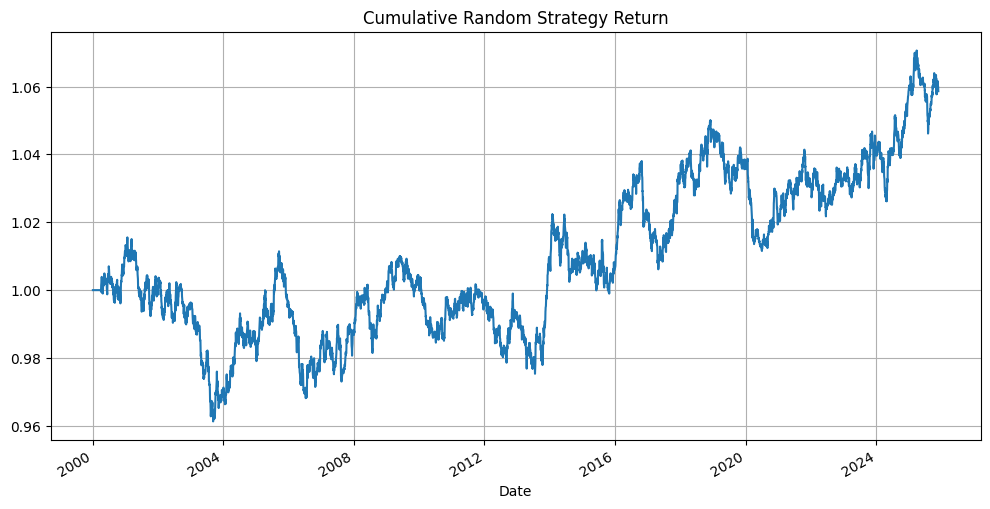

In [ ]:
(random_daily_returns*1e-4+1).cumprod().plot(figsize=(12,6), title='Cumulative Random Strategy Return', grid=True)

In [ ]:
print('Sharpe for Random strategy:', round(random_daily_returns.mean()/random_daily_returns.std()*np.sqrt(252), 3))

Sharpe for Random strategy: 0.149


In [ ]:
DICT_ALL_RESULTS['Random strategy'] = random_daily_returns

## Momentum Strategies

In [ ]:
df = pd.read_parquet('df_base.pq')

### Simple Momentum Strategy

In [ ]:
def compute_signal(x):
    if x.notna().sum() == 0:
        return pd.Series([np.nan]*len(x), index=x.index)
    ranks = x.rank(method='first')
    binned = pd.cut(ranks, bins=10, labels=False, include_lowest=True)
    signal = binned.map(lambda y: -1 if y == 0 else (1 if y == 9 else 0))
    return signal

In [ ]:
df['momentum_signal'] = df.groupby('Date')['close_1d_ret_hedged_normalised_lag1'].transform(compute_signal)

In [ ]:
momentum_daily_returns = df.groupby('Date').apply(lambda x: (x['momentum_signal'] * x['close_1d_ret']*x['vol_target_weight']).sum()/70)

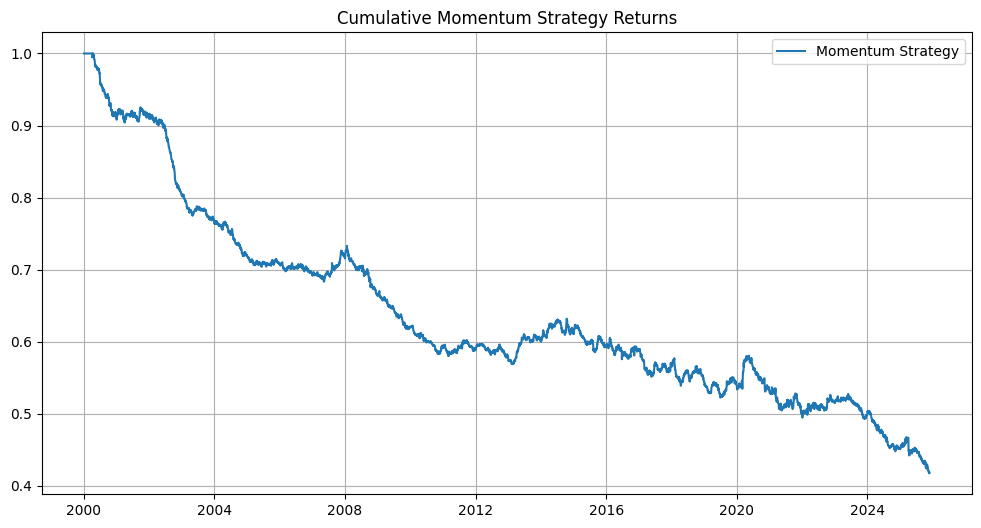

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot((1 + momentum_daily_returns*1e-4).cumprod(), label='Momentum Strategy')
plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print('Sharpe for Momentum Daily strategy:', round(momentum_daily_returns.mean()/momentum_daily_returns.std()*np.sqrt(252), 3))

Sharpe for Momentum Daily strategy: -0.909


In [ ]:
DICT_ALL_RESULTS['Momentum Daily strategy'] = momentum_daily_returns

In [ ]:
monthly_returns = np.log(data['Close'].resample('MS').first()).diff().iloc[1:]

In [ ]:
monthly_returns_normalised = monthly_returns/(np.log(data['Close']).diff().rolling(21).std()*np.sqrt(12)).resample('MS').first().iloc[1:]

In [ ]:
monthly_momentum_rank = monthly_returns_normalised.rank(method='first', axis=1)
monthly_momentum_bin = monthly_momentum_rank.apply(lambda row: pd.cut(row, bins=10, labels=False, include_lowest=True), axis=1)
monthly_momentum_signal = monthly_momentum_bin.map(lambda y: -1 if y == 0 else (1 if y == 9 else 0)).shift()

In [ ]:
monthly_momentum_returns = (monthly_momentum_signal*monthly_returns).sum(1)/70

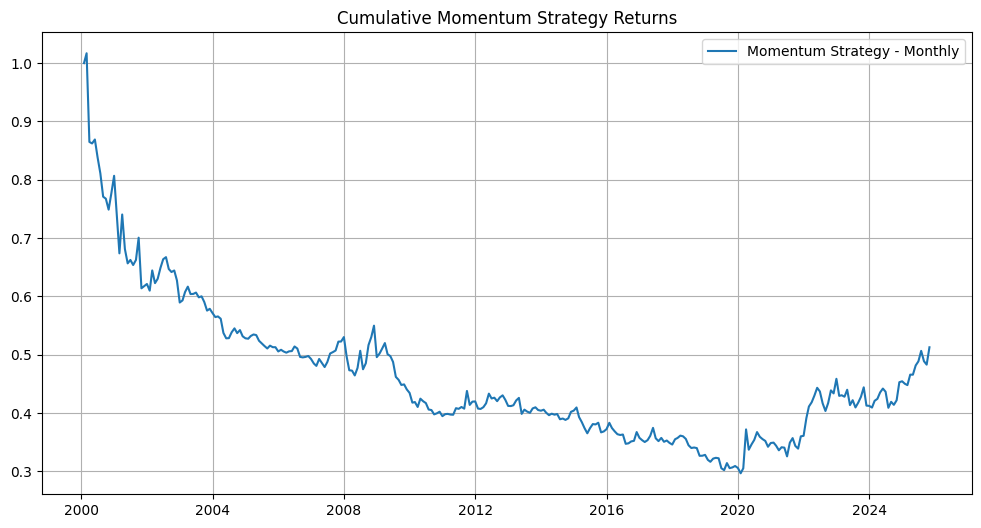

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot((monthly_momentum_returns+1).cumprod(), label='Momentum Strategy - Monthly')
plt.title('Cumulative Momentum Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print('Sharpe for Momentum Monthly strategy:', round(monthly_momentum_returns.mean()/monthly_momentum_returns.std()*np.sqrt(252), 3))

Sharpe for Momentum Monthly strategy: -0.775


In [ ]:
DICT_ALL_RESULTS['Momentum Monthly strategy'] = monthly_momentum_returns

### MACD Vol adjusted Strategy

In [ ]:
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]

In [ ]:
for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
    macd_adj_series = (df.groupby('Ticker')['close_1d_ret_hedged_normalised'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret_hedged'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret_hedged'].rolling(63).std()
    macd_adj_series.name = f'macd_adj_{i+1}'
    df = df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
    df[f'macd_adj_{i+1}'] /= df[f'macd_adj_{i+1}'].rolling(252).std()

In [ ]:
def phi_baz(x):
    return x / np.sqrt(1 + x**2)

In [ ]:
df['macd_baz_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(phi_baz).sum(1).replace(0, np.nan)
df['macd_baz_signal'] = df.groupby('Date')['macd_baz_signal'].transform(compute_signal)

In [ ]:
df['macd_tanh_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(np.tanh).sum(1).replace(0, np.nan)
df['macd_tanh_signal']  = df.groupby('Date')['macd_tanh_signal'].transform(compute_signal)

In [ ]:
df['macd_baz_signal'] = df.groupby('Ticker')['macd_baz_signal'].shift()
df['macd_tanh_signal'] = df.groupby('Ticker')['macd_tanh_signal'].shift()

In [ ]:
macd_daily_returns = df.groupby('Date').apply(
    lambda x: pd.Series({
        'baz': (x['macd_baz_signal'] * x['close_1d_ret'] * x['vol_target_weight']).sum()/70,
        'tanh': (x['macd_tanh_signal'] * x['close_1d_ret'] * x['vol_target_weight']).sum()/70
    })
)

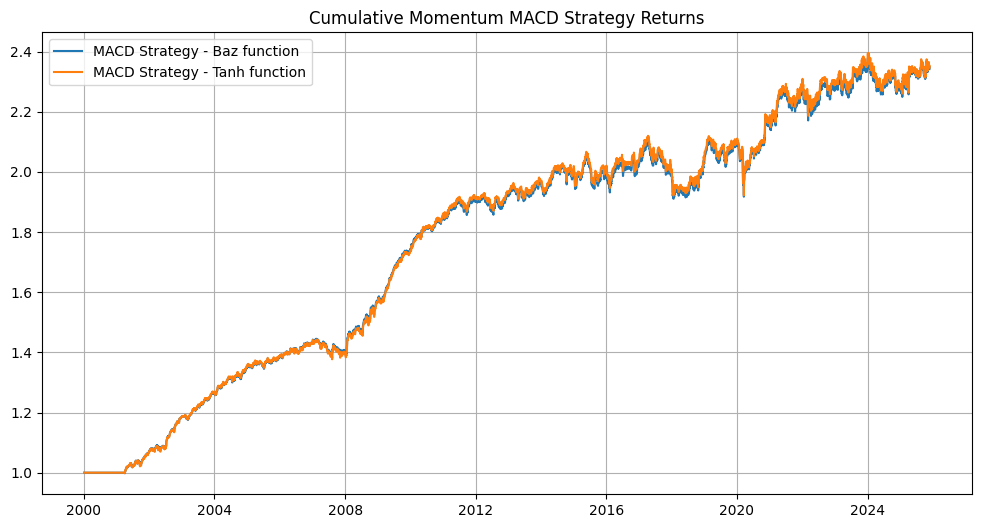

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot((1 + macd_daily_returns['baz']*1e-4).cumprod(), label='MACD Strategy - Baz function')
plt.plot((1 + macd_daily_returns['tanh']*1e-4).cumprod(), label='MACD Strategy - Tanh function')

plt.title('Cumulative Momentum MACD Strategy Returns')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print('Sharpe for MACD strategy with tanh:', round(macd_daily_returns['tanh'].mean()/macd_daily_returns['tanh'].std()*np.sqrt(252), 3))
print('Sharpe for MACD strategy with baz:', round(macd_daily_returns['baz'].mean()/macd_daily_returns['baz'].std()*np.sqrt(252), 3))

Sharpe for MACD strategy with tanh: 0.856
Sharpe for MACD strategy with baz: 0.854


In [ ]:
DICT_ALL_RESULTS['Momentum MACD strategy'] = macd_daily_returns['tanh']

# Regress-then-rank Strategies 

In [ ]:
df = pd.read_parquet('df_base.pq')

## Linear Regression

### Feature factory

In [ ]:
with open("linear_features.pkl", "rb") as f:
    linear_features = pkl.load(f)

In [ ]:
all_linear_features = copy.deepcopy(linear_features)

In [ ]:
for feature in tqdm(linear_features):
    for h in [3, 5, 10, 15, 20, 30, 60, 80]:
        df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
        df[f'zscore_{feature}_{h}d'] = (df[feature]-df[f'avg_{feature}_{h}d'])/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
        df[f'sharpe_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())
        all_linear_features.append(f'avg_{feature}_{h}d')
        all_linear_features.append(f'zscore_{feature}_{h}d')
        all_linear_features.append(f'sharpe_{feature}_{h}d')

In [ ]:
df.to_parquet('df_all_linear_features.pq')

In [ ]:
with open("all_linear_features.pkl", "wb") as f:
    pkl.dump(all_linear_features, f)

### Article features

In [ ]:
df = pd.read_parquet('df_base.pq')

In [ ]:
article_features = []

feature = 'close_1d_ret'
for h in [3, 5, 20, 60]:
    df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).mean())
    df[f'avg_{feature}_{h}d'] = df.groupby('Ticker')[f'avg_{feature}_{h}d'].shift()
    df[f'vol_{h}d'] = df.groupby('Ticker')[feature].transform(lambda x: x.rolling(h).std())*np.sqrt(252)
    df[f'vol_{h}d'] = df.groupby('Ticker')[f'vol_{h}d'].shift()
    df[f'avg_normalised_{feature}_{h}d'] = df[f'avg_{feature}_{h}d']/df[f'vol_{h}d']
    article_features.append(f'avg_{feature}_{h}d')
    article_features.append(f'avg_normalised_{feature}_{h}d')

#### Test for MACD Features

In [ ]:
test_df = df[['Ticker']]
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]
for window in tqdm([21, 63, 126, 252]):
    for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
        macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
        macd_adj_series.name = f'macd_adj_first_{window}_{i+1}'
        test_df = test_df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
        test_df[f'macd_adj_first_{window}_{i+1}'] /= test_df[f'macd_adj_first_{window}_{i+1}'].rolling(window).std()

for window in tqdm([21, 63, 126, 252]):
    for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
        macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(window).std()
        macd_adj_series.name = f'macd_adj_second_{window}_{i+1}'
        test_df = test_df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
        test_df[f'macd_adj_second_{window}_{i+1}'] /= test_df[f'macd_adj_second_{window}_{i+1}'].rolling(252).std()

100%|██████████| 4/4 [00:22<00:00,  5.62s/it]


In [ ]:
test_df.drop(columns='Ticker').corr()

,macd_adj_first_21_1,macd_adj_first_21_2,macd_adj_first_21_3,macd_adj_first_63_1,macd_adj_first_63_2,macd_adj_first_63_3,macd_adj_first_126_1,macd_adj_first_126_2,macd_adj_first_126_3,macd_adj_first_252_1,...,macd_adj_second_21_3,macd_adj_second_63_1,macd_adj_second_63_2,macd_adj_second_63_3,macd_adj_second_126_1,macd_adj_second_126_2,macd_adj_second_126_3,macd_adj_second_252_1,macd_adj_second_252_2,macd_adj_second_252_3
macd_adj_first_21_1,1.000000,0.861620,0.540281,0.959881,0.848082,0.595314,0.951320,0.837206,0.585213,0.949353,...,0.578902,0.949353,0.833026,0.574956,0.927433,0.814070,0.563714,0.910140,0.799369,0.554106
macd_adj_first_21_2,0.861620,1.000000,0.818506,0.820366,0.941084,0.835528,0.812807,0.933320,0.836716,0.811021,...,0.851447,0.811021,0.931987,0.833341,0.792478,0.910901,0.816490,0.777945,0.894606,0.802449
macd_adj_first_21_3,0.540281,0.818506,1.000000,0.524526,0.765399,0.913384,0.521727,0.759279,0.905968,0.519830,...,0.937482,0.519830,0.758070,0.908883,0.508127,0.741039,0.887973,0.498989,0.728361,0.873134
macd_adj_first_63_1,0.959881,0.820366,0.524526,1.000000,0.878583,0.612412,0.987690,0.862282,0.597993,0.984154,...,0.559451,0.984154,0.855436,0.585218,0.953077,0.828737,0.568899,0.933916,0.812669,0.558567
macd_adj_first_63_2,0.848082,0.941084,0.765399,0.878583,1.000000,0.872722,0.868569,0.983968,0.862759,0.865411,...,0.825597,0.865411,0.978335,0.852805,0.838703,0.948294,0.828754,0.821857,0.929740,0.813228
macd_adj_first_63_3,0.595314,0.835528,0.913384,0.612412,0.872722,1.000000,0.608132,0.861677,0.973695,0.605835,...,0.944694,0.605835,0.857064,0.966218,0.587630,0.831452,0.937243,0.575796,0.815350,0.919808
macd_adj_first_126_1,0.951320,0.812807,0.521727,0.987690,0.868569,0.608132,1.000000,0.874762,0.606673,0.994722,...,0.562337,0.994722,0.866338,0.592569,0.977154,0.851303,0.584320,0.952973,0.830898,0.571129
macd_adj_first_126_2,0.837206,0.933320,0.759279,0.862282,0.983968,0.861677,0.874762,1.000000,0.879073,0.870250,...,0.833688,0.870250,0.992552,0.866632,0.855113,0.975086,0.853562,0.834027,0.951572,0.833815
macd_adj_first_126_3,0.585213,0.836716,0.905968,0.597993,0.862759,0.973695,0.606673,0.879073,1.000000,0.603611,...,0.959870,0.603611,0.873279,0.988004,0.593692,0.858316,0.971099,0.579082,0.837780,0.948534
macd_adj_first_252_1,0.949353,0.811021,0.519830,0.984154,0.865411,0.605835,0.994722,0.870250,0.603611,1.000000,...,0.563990,1.000000,0.871960,0.596320,0.987959,0.861714,0.591426,0.970610,0.847150,0.582291


#### End of test

In [ ]:
short_span_list = [8, 16, 32]
long_span_list = [24, 48, 96]

for i, (short_span, long_span) in enumerate(zip(short_span_list, long_span_list)):
    macd_adj_series = (df.groupby('Ticker')['close_1d_ret'].ewm(span=short_span, adjust=False).mean() - df.groupby('Ticker')['close_1d_ret'].ewm(span=long_span, adjust=False).mean())/df.groupby('Ticker')['close_1d_ret'].rolling(63).std()
    macd_adj_series.name = f'macd_adj_{i+1}'
    df = df.merge(macd_adj_series, on=['Date', 'Ticker'], how='right')
    df[f'macd_adj_{i+1}'] /= df[f'macd_adj_{i+1}'].rolling(252).std()
    df[f'macd_adj_{i+1}'] = df.groupby('Ticker')[f'macd_adj_{i+1}'].shift()
    article_features.append(f'macd_adj_{i+1}')

In [ ]:
def phi_baz(x):
    return x / np.sqrt(1 + x**2)

In [ ]:
df['macd_baz_signal'] = df[['macd_adj_1', 'macd_adj_2', 'macd_adj_3']].apply(phi_baz).sum(1).replace(0, np.nan)
article_features.append('macd_baz_signal')

In [ ]:
df[article_features].corr()

,avg_close_1d_ret_3d,avg_normalised_close_1d_ret_3d,avg_close_1d_ret_5d,avg_normalised_close_1d_ret_5d,avg_close_1d_ret_20d,avg_normalised_close_1d_ret_20d,avg_close_1d_ret_60d,avg_normalised_close_1d_ret_60d,macd_adj_1,macd_adj_2,macd_adj_3,macd_baz_signal
avg_close_1d_ret_3d,1.000000,0.114855,0.765642,0.545281,0.383271,0.318139,0.213141,0.191705,0.739663,0.667016,0.538634,0.662393
avg_normalised_close_1d_ret_3d,0.114855,1.000000,0.087811,0.130676,0.043803,0.055418,0.026496,0.032584,0.117263,0.105266,0.084453,0.112880
avg_close_1d_ret_5d,0.765642,0.087811,1.000000,0.711500,0.494627,0.407786,0.274889,0.245921,0.694607,0.728273,0.635699,0.711281
avg_normalised_close_1d_ret_5d,0.545281,0.130676,0.711500,1.000000,0.348050,0.436181,0.205395,0.254342,0.689502,0.719935,0.626121,0.749243
avg_close_1d_ret_20d,0.383271,0.043803,0.494627,0.348050,1.000000,0.811977,0.557069,0.480466,0.185606,0.464135,0.678393,0.464480
avg_normalised_close_1d_ret_20d,0.318139,0.055418,0.407786,0.436181,0.811977,1.000000,0.456023,0.554212,0.213221,0.530765,0.776427,0.546803
avg_close_1d_ret_60d,0.213141,0.026496,0.274889,0.205395,0.557069,0.456023,1.000000,0.841012,0.024189,0.082917,0.284334,0.117988
avg_normalised_close_1d_ret_60d,0.191705,0.032584,0.245921,0.254342,0.480466,0.554212,0.841012,1.000000,0.035479,0.106909,0.343621,0.151731
macd_adj_1,0.739663,0.117263,0.694607,0.689502,0.185606,0.213221,0.024189,0.035479,1.000000,0.871975,0.596364,0.842675
macd_adj_2,0.667016,0.105266,0.728273,0.719935,0.464135,0.530765,0.082917,0.106909,0.871975,1.000000,0.875274,0.953197


In [ ]:
class Winsorizer(BaseEstimator, TransformerMixin):
    """
    Transformateur pour winsoriser les features.
    Les limites sont apprises sur le train set et appliquées au test set.
    """
    def __init__(self, lower=0.01, upper=0.01):
        self.lower = lower
        self.upper = upper
        self.lower_bounds_ = None
        self.upper_bounds_ = None
    
    def fit(self, X, y=None):
        """Apprend les limites de winsorisation sur X"""
        if isinstance(X, pd.DataFrame):
            self.lower_bounds_ = X.quantile(self.lower)
            self.upper_bounds_ = X.quantile(1 - self.upper)
            self.feature_names_ = X.columns
        else:
            # Pour numpy array
            self.lower_bounds_ = np.percentile(X, self.lower * 100, axis=0)
            self.upper_bounds_ = np.percentile(X, (1 - self.upper) * 100, axis=0)
        
        return self
    
    def transform(self, X):
        """Applique la winsorisation avec les limites apprises"""
        if self.lower_bounds_ is None or self.upper_bounds_ is None:
            raise ValueError("Winsorizer must be fitted before transform")
        
        X_copy = X.copy()
        
        if isinstance(X, pd.DataFrame):
            for col in X.columns:
                X_copy[col] = np.clip(X_copy[col], 
                                     self.lower_bounds_[col], 
                                     self.upper_bounds_[col])
        else:
            # Pour numpy array
            X_copy = np.clip(X_copy, self.lower_bounds_, self.upper_bounds_)
        
        return X_copy

In [ ]:
X = df[article_features + ["close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()[article_features]
y = df[article_features + ["close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret_hedged_normalised"]

split_date = X.index.unique().sort_values()[int(X.index.nunique()*0.8)]

X_train = X.loc[X.index<split_date]
X_test = X.loc[X.index>=split_date]
y_train = y.loc[y.index<split_date]
y_test = y.loc[y.index>=split_date]

In [ ]:
ols_baseline = Pipeline([
    ('winsorizer', Winsorizer(lower=0.001, upper=0.001)),
    ('reg', LinearRegression(fit_intercept=False))
])

In [ ]:
ols_baseline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('winsorizer', ...), ('reg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,lower,0.001
,upper,0.001
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",False
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [ ]:
X_train.columns

Index(['avg_close_1d_ret_3d', 'avg_normalised_close_1d_ret_3d',
       'avg_close_1d_ret_5d', 'avg_normalised_close_1d_ret_5d',
       'avg_close_1d_ret_20d', 'avg_normalised_close_1d_ret_20d',
       'avg_close_1d_ret_60d', 'avg_normalised_close_1d_ret_60d', 'macd_adj_1',
       'macd_adj_2', 'macd_adj_3', 'macd_baz_signal'],
      dtype='object')

In [ ]:
ols_baseline.named_steps['reg'].coef_

array([-4.63714541e-05, -3.41430172e-02, -5.40794281e-05, -5.80042804e-02,
        1.27906331e-04,  2.72847294e-02, -2.95791761e-04,  1.22335421e+00,
        6.51337770e-03, -4.61828836e-03, -1.18936583e-02,  7.69606100e-03])

In [ ]:
y_pred = ols_baseline.predict(X_test)

In [ ]:
df_test = df[df.index>=split_date][article_features + ["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]]
# df_test = df[df.index>=split_date].replace([-np.inf, np.inf], np.nan).dropna()

In [ ]:
df_test['y_pred'] = y_pred

In [ ]:
def compute_signal(x):
    if x.notna().sum() == 0:
        return pd.Series([np.nan]*len(x), index=x.index)
    ranks = x.rank(method='first')
    binned = pd.cut(ranks, bins=10, labels=False, include_lowest=True)
    signal = binned.map(lambda y: -1 if y == 0 else (1 if y == 9 else 0))
    return signal

In [ ]:
df_test['ols_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)

In [ ]:
df_test = df_test.merge(df[['Ticker', 'vol_target_weight']], on=['Date', 'Ticker'], how='left')

In [ ]:
ols_daily_returns = df_test.groupby('Date').apply(lambda x: (x['ols_signal']*x['close_1d_ret']*x['vol_target_weight']).sum()/70)

<Axes: title={'center': 'Cumulative OLS Baseline Strategy Return'}, xlabel='Date'>

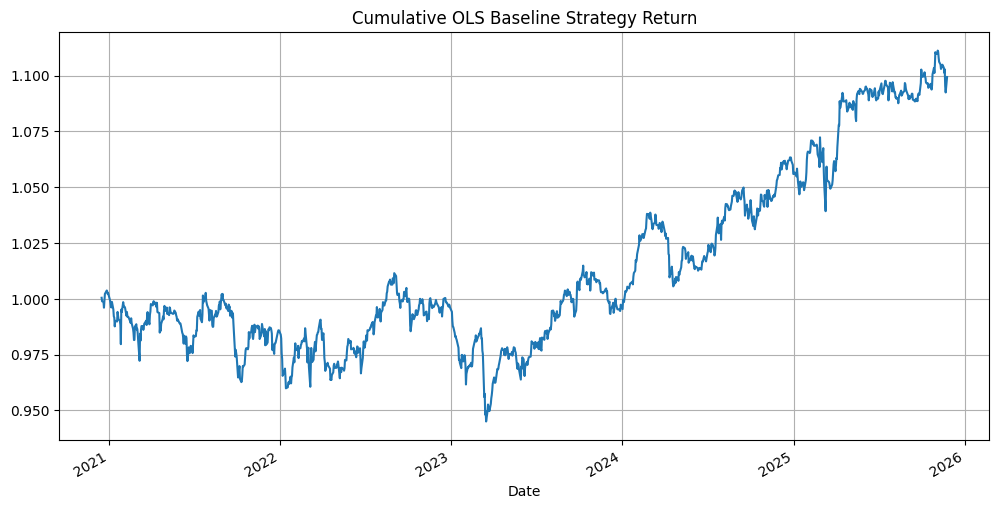

In [ ]:
(ols_daily_returns*1e-4+1).cumprod().plot(figsize=(12,6), title='Cumulative OLS Baseline Strategy Return', grid=True)

In [ ]:
print('Sharpe for OLS baseline strategy:', round(ols_daily_returns.mean()/ols_daily_returns.std()*np.sqrt(252), 3))

Sharpe for OLS baseline strategy: 0.442


In [ ]:
DICT_ALL_RESULTS['OLS Baseline strategy'] = ols_daily_returns

### All features

In [ ]:
with open("all_linear_features.pkl", "rb") as f:
    all_linear_features = pkl.load(f)

In [ ]:
df = pd.read_parquet('df_all_linear_features.pq')

In [ ]:
X = df[all_linear_features + ["close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()[all_linear_features]
y = df[all_linear_features + ["close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()["close_1d_ret_hedged_normalised"]

split_date = X.index.unique().sort_values()[int(X.index.nunique()*0.8)]

X_train = X.loc[X.index<split_date]
X_test = X.loc[X.index>=split_date]
y_train = y.loc[y.index<split_date]
y_test = y.loc[y.index>=split_date]

In [ ]:
ols_baseline.fit(X_train.to_numpy(), y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('winsorizer', ...), ('reg', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,lower,0.001
,upper,0.001
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",False
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [ ]:
y_pred = ols_baseline.predict(X_test.to_numpy())
df_test = df[df.index>=split_date][all_linear_features + ["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]]
df_test['y_pred'] = y_pred

In [ ]:
df_test['ols_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)
df_test = df_test.merge(df[['Ticker', 'vol_target_weight']], on=['Date', 'Ticker'], how='left')
ols_daily_returns = df_test.groupby('Date').apply(lambda x: (x['ols_signal']*x['close_1d_ret']*x['vol_target_weight']).sum()/70)

<Axes: title={'center': 'Cumulative OLS all features Strategy Return'}, xlabel='Date'>

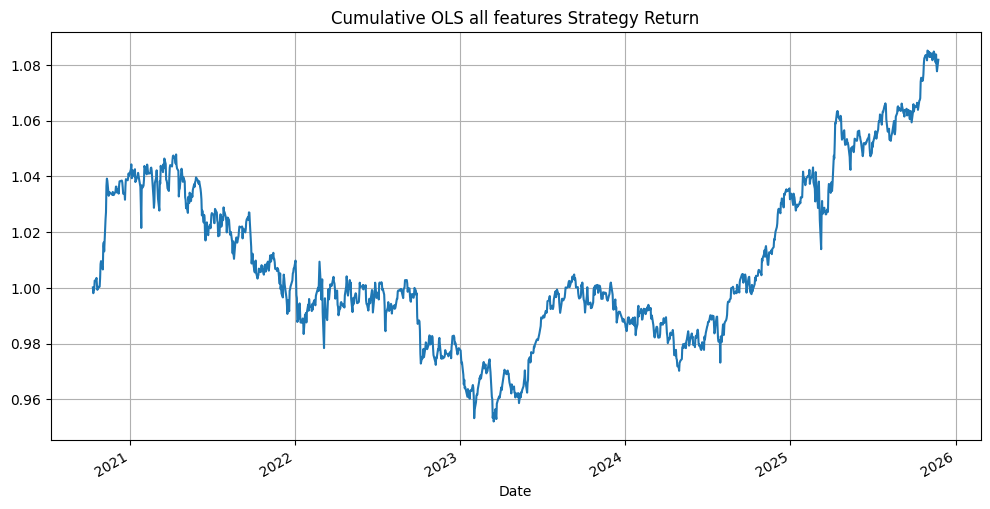

In [ ]:
(ols_daily_returns*1e-4+1).cumprod().plot(figsize=(12,6), title='Cumulative OLS all features Strategy Return', grid=True)

In [ ]:
print('Sharpe for OLS all linear features strategy:', round(ols_daily_returns.mean()/ols_daily_returns.std()*np.sqrt(252), 3))

Sharpe for OLS all linear features strategy: 0.383


In [ ]:
DICT_ALL_RESULTS['OLS All features strategy'] = ols_daily_returns

### All features + PCA

In [ ]:
ols_pca = Pipeline([
    ('winsorizer', Winsorizer(lower=0.001, upper=0.001)),
    ('pca', PCA(n_components=0.95)),
    ('reg', LinearRegression(fit_intercept=False))
])

In [ ]:
ols_pca.fit(X_train.to_numpy(), y_train)
y_pred_pca = ols_pca.predict(X_test.to_numpy())
df_test = df[df.index>=split_date][all_linear_features + ["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]]
df_test['y_pred'] = y_pred_pca
df_test['ols_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)
df_test = df_test.merge(df[['Ticker', 'vol_target_weight']], on=['Date', 'Ticker'], how='left')
ols_pca_daily_returns = df_test.groupby('Date').apply(lambda x: (x['ols_signal']*x['close_1d_ret']*x['vol_target_weight']).sum()/70)

<Axes: title={'center': 'Cumulative OLS + PCA Strategy Return'}, xlabel='Date'>

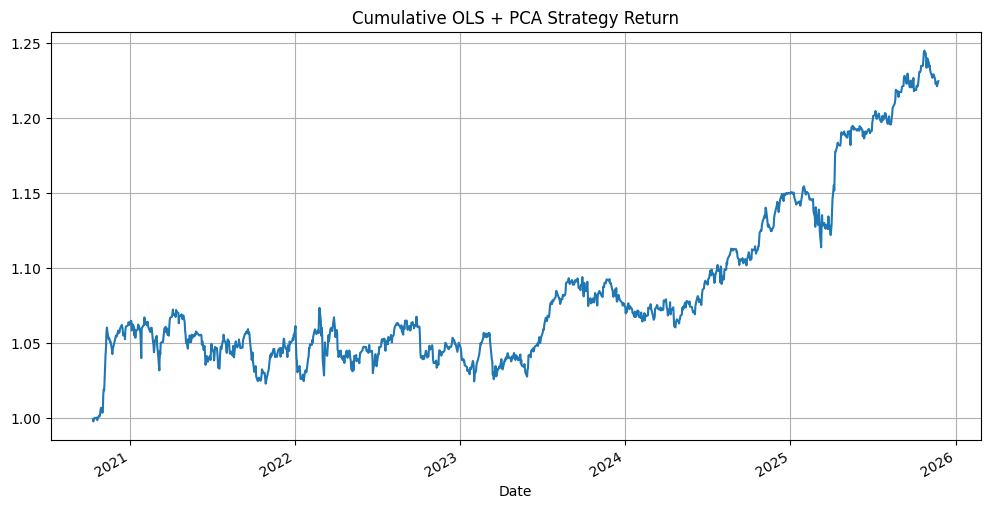

In [ ]:
(ols_pca_daily_returns*1e-4+1).cumprod().plot(figsize=(12,6), title='Cumulative OLS + PCA Strategy Return', grid=True)

In [ ]:
print('Sharpe for OLS+PCA all linear features strategy:', round(ols_pca_daily_returns.mean()/ols_pca_daily_returns.std()*np.sqrt(252), 3))

Sharpe for OLS+PCA all linear features strategy: 0.795


In [ ]:
DICT_ALL_RESULTS['OLS+PCA All features strategy'] = ols_pca_daily_returns

## LGBM Regressor

#### Non linear features factory

In [ ]:
df = pd.read_parquet('df_all_linear_features.pq')

In [ ]:
with open("all_linear_features.pkl", "rb") as f:
    all_linear_features = pkl.load(f)
    
with open("non_linear_features.pkl", "rb") as f:
    non_linear_features = pkl.load(f)

In [ ]:
all_features = all_linear_features + non_linear_features

In [ ]:
for window in tqdm([5, 10, 21, 42, 63, 126, 252]):
    df[f'vol_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.rolling(window).std().shift())
    df[f'kurt_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.rolling(window).kurt().shift())
    df[f'skew_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.rolling(window).skew().shift())
    all_features.append(f'vol_{window}d')
    all_features.append(f'kurt_{window}d')
    all_features.append(f'skew_{window}d')
    if window>=10:
        df[f'vol_upside_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.where(x>0, 0).rolling(window).std().shift())
        df[f'vol_downside_{window}d'] = df.groupby('Ticker')['close_1d_ret'].transform(lambda x: x.where(x<0, 0).rolling(window).std().shift())
        all_features.append(f'vol_upside_{window}d')
        all_features.append(f'vol_downside_{window}d')

100%|██████████| 7/7 [00:17<00:00,  2.52s/it]


In [ ]:
df.to_parquet('df_all_features.pq')

In [ ]:
with open("all_features.pkl", "wb") as f:
    pkl.dump(all_features, f)

### First model

In [ ]:
df = pd.read_parquet('df_all_features.pq')

In [ ]:
with open("all_features.pkl", "rb") as f:
    all_features = pkl.load(f)

In [ ]:
len(all_features)

260

In [ ]:
clean_df = df[all_features + ["close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()
X = clean_df[all_features]
y = clean_df["close_1d_ret_hedged_normalised"]

split_date = X.index.unique().sort_values()[int(X.index.nunique()*0.8)]

X_train = X.loc[X.index<split_date]
X_test = X.loc[X.index>=split_date]
y_train = y.loc[y.index<split_date]
y_test = y.loc[y.index>=split_date]

In [ ]:
lgbm = Pipeline([
    # ('scaler', StandardScaler()),
    # ('pca', PCA(n_components=0.95)),
    ('model', LGBMRegressor(
        objective="regression",
        boosting_type="gbdt",
        random_state=42,
        n_jobs=-1,
        force_col_wise=True 
    ))
])

In [ ]:
%%time 
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 66300
[LightGBM] [Info] Number of data points in the train set: 1779489, number of used features: 260
[LightGBM] [Info] Start training from score 0.007649
CPU times: user 3min 24s, sys: 814 ms, total: 3min 25s
Wall time: 9.15 s


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'regression'


In [ ]:
y_pred_lgbm = lgbm.predict(X_test)

In [ ]:
df_test = df[df.index>=split_date][all_features + ["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]]

In [ ]:
df_test['y_pred'] = y_pred_lgbm

In [ ]:
df_test['lgbm_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)
df_test = df_test.merge(df[['Ticker', 'vol_target_weight']], on=['Date', 'Ticker'], how='left')
lgbm_daily_returns = df_test.groupby('Date').apply(lambda x: (x['lgbm_signal']*x['close_1d_ret']*x['vol_target_weight']).sum()/70)

<Axes: title={'center': 'Cumulative LGBM Strategy Return'}, xlabel='Date'>

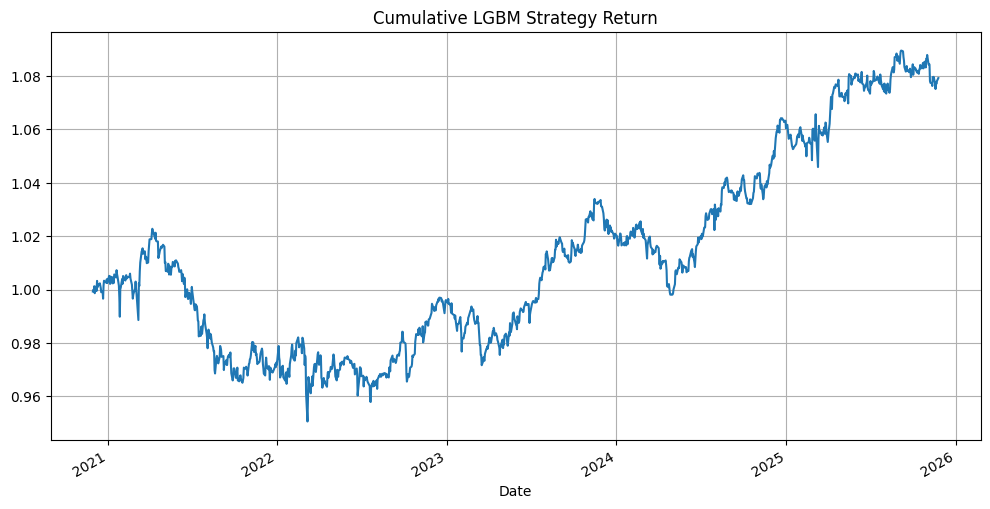

In [ ]:
(lgbm_daily_returns*1e-4+1).cumprod().plot(figsize=(12,6), title='Cumulative LGBM Strategy Return', grid=True)

In [ ]:
print('Sharpe for simple LGBM strategy:', round(lgbm_daily_returns.mean()/lgbm_daily_returns.std()*np.sqrt(252), 3))

Sharpe for simple LGBM strategy: 0.421


In [ ]:
DICT_ALL_RESULTS['Simple LGBM strategy'] = lgbm_daily_returns

### Hyperparameter optimization

In [ ]:
class ExpandingWindowCV(_BaseKFold):
    """
    Expanding Window Cross-Validator with fixed test size based on unique dates.
    
    This cross-validator creates splits where:
    - Split 1: Train on first 50% of unique dates, test on next 15% of unique dates
    - Split 2: Train on first 65% of unique dates, test on next 15% of unique dates
    - Split 3: Train on first 85% of unique dates, test on last 15% of unique dates
    
    The DataFrame is expected to be indexed by dates, with potentially multiple rows per date.
    The split is performed on unique dates, and all rows corresponding to dates in the 
    train/test periods are included in the respective sets.
    
    Parameters
    ----------
    n_splits : int, default=3
        Number of folds (fixed at 3 for this implementation)
    """
    
    def __init__(self, n_splits=3):
        super().__init__(n_splits=n_splits, shuffle=False, random_state=None)
        if n_splits != 3:
            raise ValueError("This implementation is designed for exactly 3 splits")
    
    def split(self, X, y=None, groups=None):
        """
        Generate indices to split data into training and test set based on unique dates.
        
        Parameters
        ----------
        X : pandas DataFrame with DatetimeIndex
            Training data indexed by dates
        y : array-like of shape (n_samples,), default=None
            Target variable
        groups : array-like of shape (n_samples,), default=None
            Group labels (not used)
            
        Yields
        ------
        train : ndarray
            The training set indices for that split
        test : ndarray
            The testing set indices for that split
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("X must be a pandas DataFrame with DatetimeIndex")
        
        if not isinstance(X.index, pd.DatetimeIndex):
            raise TypeError("X must have a DatetimeIndex")
        
        # Get unique dates and sort them
        unique_dates = pd.Series(X.index.unique()).sort_values().values
        n_unique_dates = len(unique_dates)
        
        # Define train/test boundaries as percentages of unique dates
        splits_config = [
            (0.50, 0.65),  # Train: 0-50%, Test: 50-65%
            (0.65, 0.80),  # Train: 0-65%, Test: 65-80%
            (0.85, 1.00),  # Train: 0-85%, Test: 85-100%
        ]
        
        for train_end_pct, test_end_pct in splits_config:
            train_end_idx = int(np.floor(train_end_pct * n_unique_dates))
            test_end_idx = int(np.floor(test_end_pct * n_unique_dates))
            
            # Get the date boundaries
            train_dates = unique_dates[:train_end_idx]
            test_dates = unique_dates[train_end_idx:test_end_idx]
            
            # Get all row indices corresponding to these dates
            train_indices = np.where(X.index.isin(train_dates))[0]
            test_indices = np.where(X.index.isin(test_dates))[0]
            
            yield train_indices, test_indices
    
    def get_n_splits(self, X=None, y=None, groups=None):
        """Returns the number of splitting iterations in the cross-validator"""
        return self.n_splits

In [ ]:
cv = ExpandingWindowCV(n_splits=3)

In [ ]:
param_distributions = {
    'model__num_leaves': [20, 31, 50, 75],
    'model__learning_rate': [0.005, 0.01, 0.03],
    'model__n_estimators': [100, 200, 300, 500],

    'model__min_child_samples': [50, 100, 150, 200, 500],
    'model__min_child_weight': [0.01, 0.1, 1],
    'model__reg_alpha': [0.1, 1, 5, 10],
    'model__reg_lambda': [0.1, 1, 5, 10],

    'model__subsample': [0.7, 0.8, 0.85],
    'model__subsample_freq': [1],
    'model__colsample_bytree': [0.7, 0.8, 0.85],

    'model__max_depth': [5, 7, 9],
}

In [ ]:
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_distributions,
    n_iter=100,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=1,
    verbose=1,
    random_state=42
)

In [ ]:
%%time
random_search.fit(X_train, y_train)

In [ ]:
with open("random_search.pkl", "wb") as f:
    pkl.dump(random_search, f)

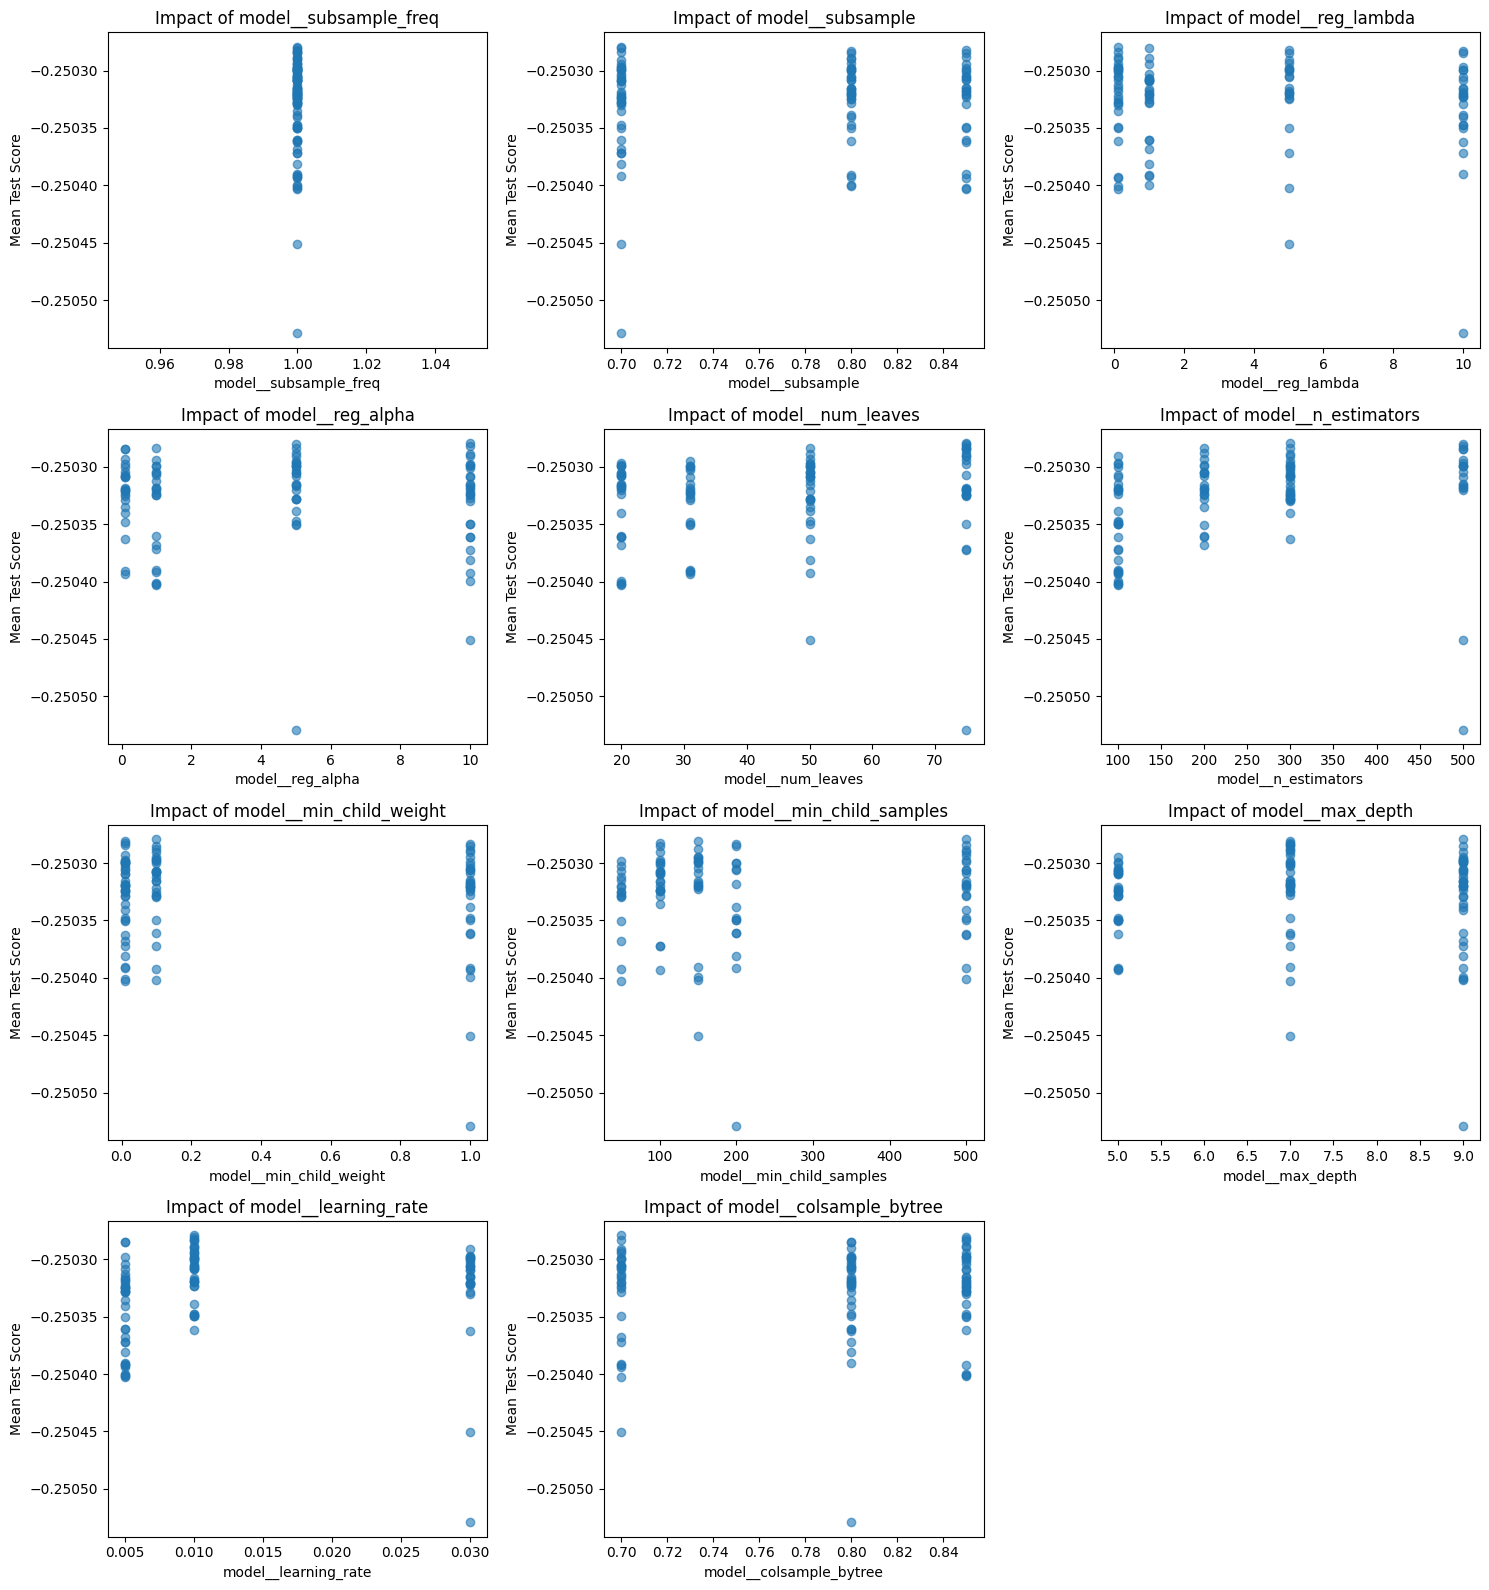

In [ ]:
results_df = pd.DataFrame(random_search.cv_results_)

# Extract parameter columns
param_cols = [col for col in results_df.columns if col.startswith('param_')]

# Create clean dataframe
plot_df = results_df[param_cols + ['mean_test_score', 'std_test_score']].copy()
plot_df.columns = [col.replace('param_', '') for col in plot_df.columns]

# Parameters to plot
params = [col for col in plot_df.columns if col not in ['mean_test_score', 'std_test_score']]
n_params = len(params)

# Dynamic subplot grid
n_cols = 3
n_rows = math.ceil(n_params / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, param in enumerate(params):
    ax = axes[idx]
    ax.scatter(plot_df[param], plot_df['mean_test_score'], alpha=0.6)
    ax.set_xlabel(param)
    ax.set_ylabel('Mean Test Score')
    ax.set_title(f'Impact of {param}')

# Remove unused subplots
for idx in range(len(params), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

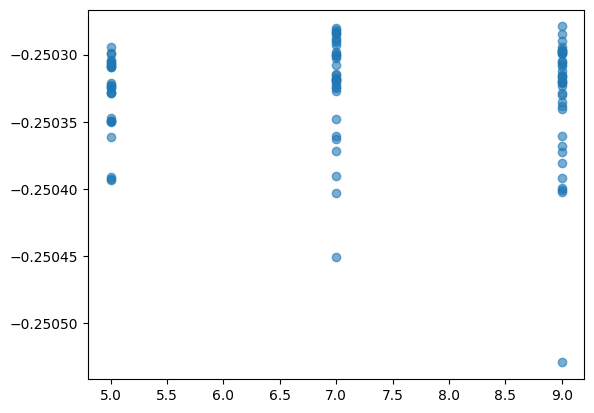

In [ ]:
param = 'model__max_depth'

plt.scatter(plot_df[param], plot_df['mean_test_score'], alpha=0.6)

In [ ]:
second_param_distributions = {
    'model__num_leaves': [20, 31, 75, 100],
    'model__learning_rate': [0.005, 0.01],
    'model__n_estimators': [200, 300, 500, 700],

    'model__min_child_samples': [100, 200, 500, 750],
    'model__min_child_weight': [0.1, 0.3, 0.5],
    'model__reg_alpha': [0.1, 0.5, 1, 2],
    'model__reg_lambda': [0.1, 0.5, 1, 3],

    'model__subsample': [0.75, 0.8, 0.85, 0.9],
    'model__subsample_freq': [1],
    'model__colsample_bytree': [0.6, 0.7, 0.8, 0.85, 0.9],

    'model__max_depth': [3, 5, 7, 9, 15],
}

In [ ]:
second_random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=second_param_distributions,
    n_iter=100,
    scoring="neg_mean_squared_error",
    cv=cv,
    n_jobs=1,
    verbose=1,
    random_state=42
)

In [ ]:
second_random_search.fit(X_train, y_train)

In [ ]:
with open("second_random_search.pkl", "wb") as f:
    pkl.dump(second_random_search, f)

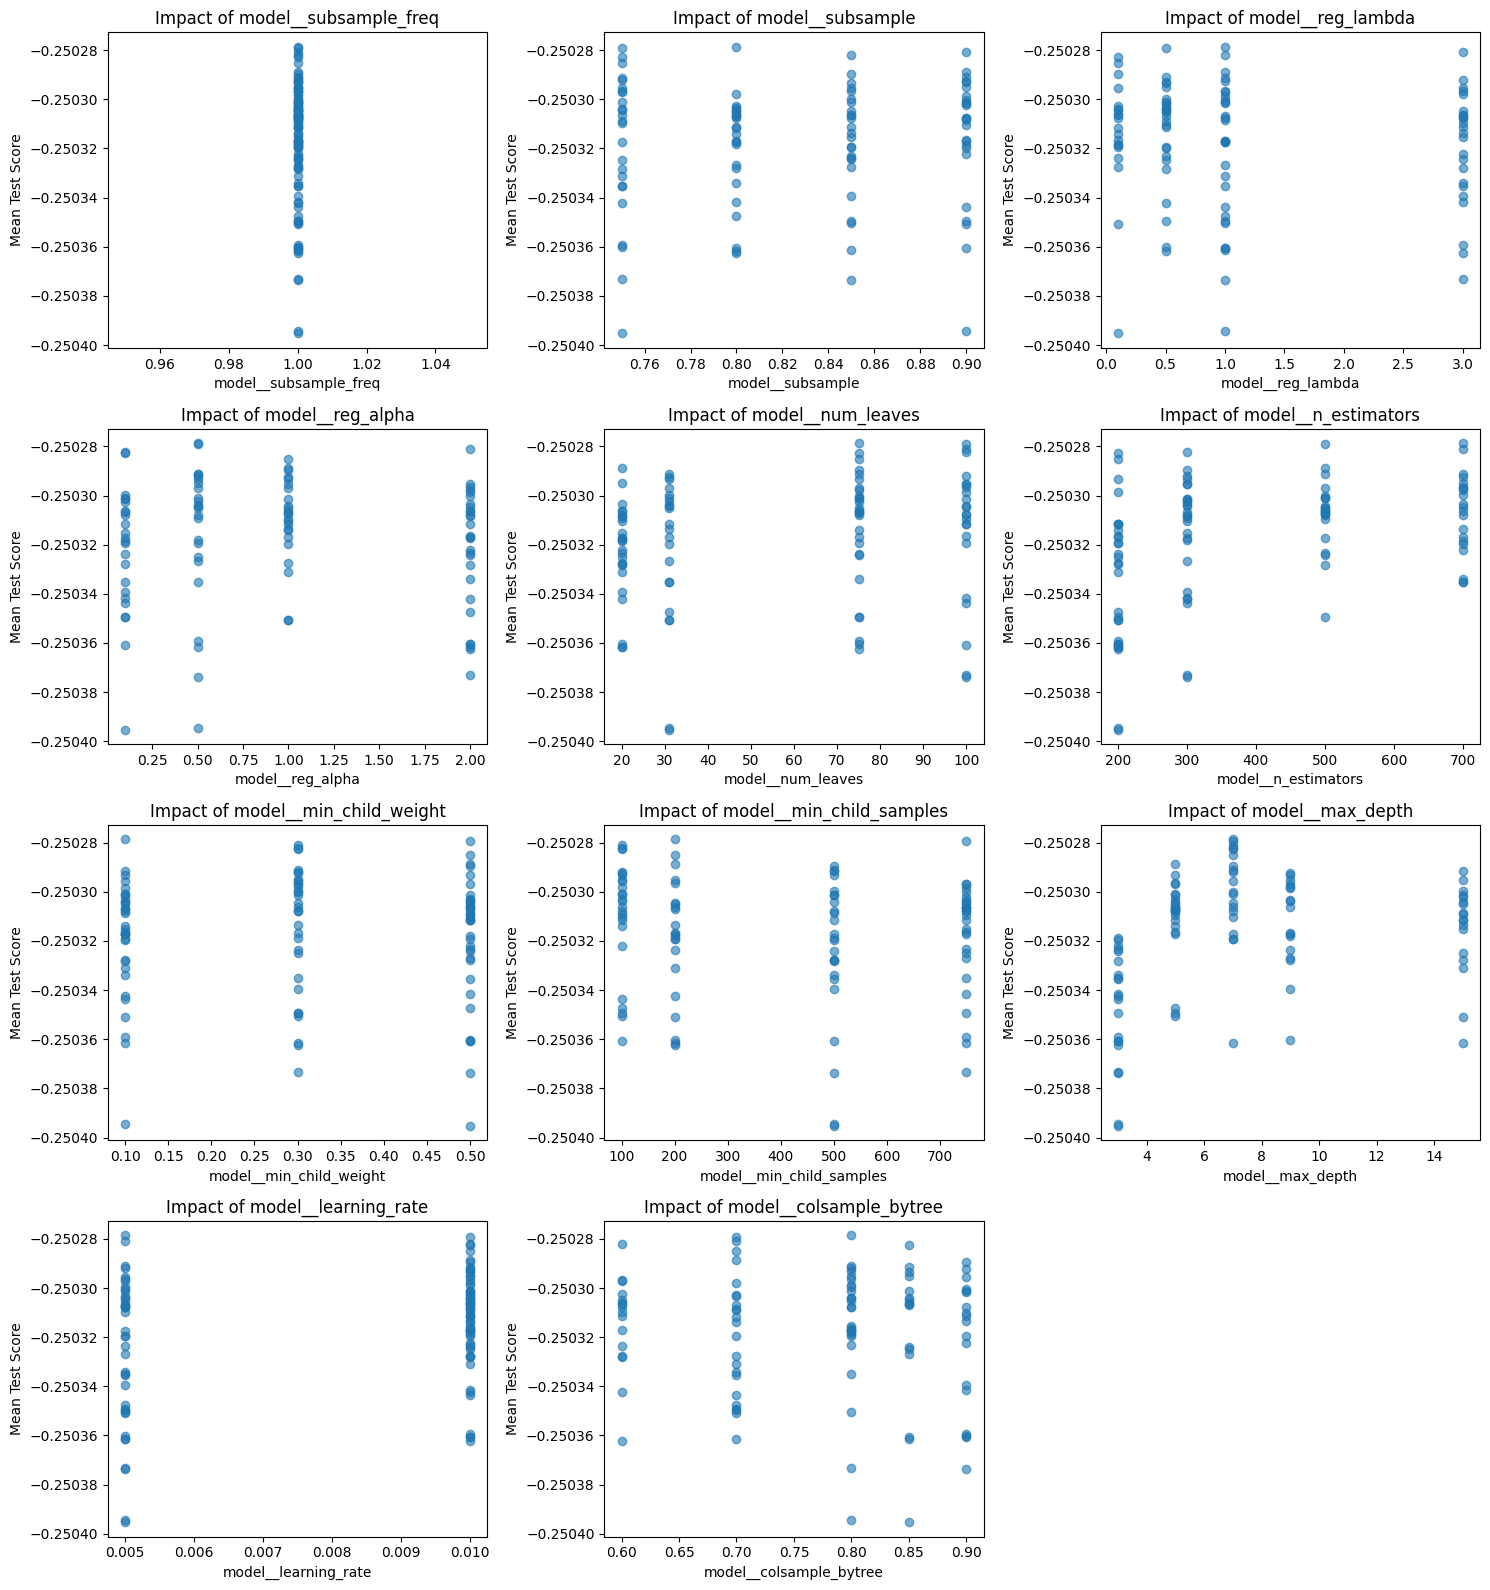

In [ ]:
results_df = pd.DataFrame(second_random_search.cv_results_)

# Extract parameter columns
param_cols = [col for col in results_df.columns if col.startswith('param_')]

# Create clean dataframe
plot_df = results_df[param_cols + ['mean_test_score', 'std_test_score']].copy()
plot_df.columns = [col.replace('param_', '') for col in plot_df.columns]

# Parameters to plot
params = [col for col in plot_df.columns if col not in ['mean_test_score', 'std_test_score']]
n_params = len(params)

# Dynamic subplot grid
n_cols = 3
n_rows = math.ceil(n_params / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, param in enumerate(params):
    ax = axes[idx]
    ax.scatter(plot_df[param], plot_df['mean_test_score'], alpha=0.6)
    ax.set_xlabel(param)
    ax.set_ylabel('Mean Test Score')
    ax.set_title(f'Impact of {param}')

# Remove unused subplots
for idx in range(len(params), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

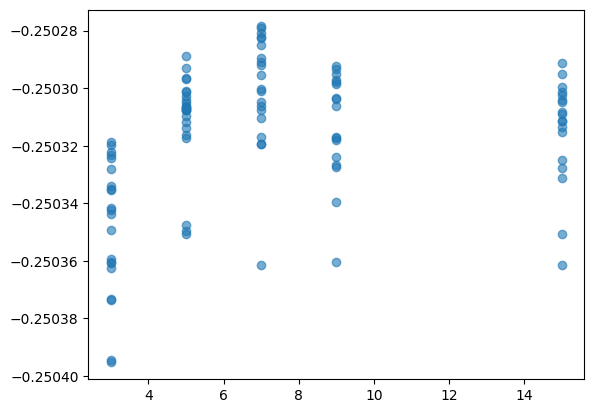

In [ ]:
type_ = 'max_depth'
param = f'model__{type_}'

plt.scatter(plot_df[param], plot_df['mean_test_score'], alpha=0.6)

### Adjusted model

In [ ]:
lgbm = Pipeline([
    # ('scaler', StandardScaler()),
    # ('pca', PCA(n_components=0.95)),
    ('model', LGBMRegressor(
        objective="regression",
        boosting_type="gbdt",
        random_state=42,
        n_jobs=-1,
        force_col_wise=True,
        num_leaves=75,
        learning_rate=0.01,
        n_estimators=700,
        min_child_samples=200,
        min_child_weight=0.3,
        reg_alpha=1,
        reg_lambda=0.5,
        subsample=0.8,
        subsample_freq=1,
        colsample_bytree=0.7,
        max_depth=7
    ))
])

In [ ]:
%%time 
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 66300
[LightGBM] [Info] Number of data points in the train set: 1779489, number of used features: 260
[LightGBM] [Info] Start training from score 0.007649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,boosting_type,'gbdt'
,num_leaves,75
,max_depth,7
,learning_rate,0.01
,n_estimators,700
,subsample_for_bin,200000
,objective,'regression'


In [ ]:
y_pred_lgbm = lgbm.predict(X_test)
df_test = df[df.index>=split_date][all_features + ["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()[["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]]
df_test['y_pred'] = y_pred_lgbm
df_test['lgbm_signal'] = df_test.groupby('Date')['y_pred'].transform(compute_signal)
df_test = df_test.merge(df[['Ticker', 'vol_target_weight']], on=['Date', 'Ticker'], how='left')
lgbm_adj_daily_returns = df_test.groupby('Date').apply(lambda x: (x['lgbm_signal']*x['close_1d_ret']*x['vol_target_weight']).sum()/70)

<Axes: title={'center': 'Cumulative Adjusted LGBM Strategy Return'}, xlabel='Date'>

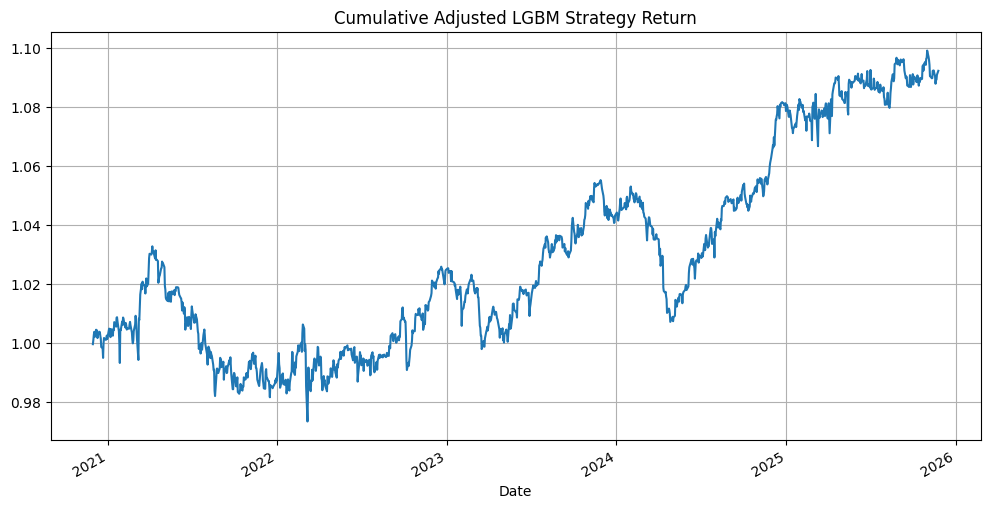

In [ ]:
(1+lgbm_adj_daily_returns*1e-4).cumprod().plot(figsize=(12,6), title='Cumulative Adjusted LGBM Strategy Return', grid=True)

In [ ]:
print('Sharpe for Adjusted LGBM Strategy:', round(lgbm_adj_daily_returns.mean()/lgbm_adj_daily_returns.std()*np.sqrt(252), 3))

Sharpe for Adjusted LGBM Strategy: 0.47


In [ ]:
DICT_ALL_RESULTS['Adjusted LGBM strategy'] = lgbm_adj_daily_returns

# LTR Strategies

## LambdaMART

### First model

In [ ]:
df = pd.read_parquet('df_all_features.pq')

with open("all_features.pkl", "rb") as f:
    all_features = pkl.load(f)

In [ ]:
from lightgbm import LGBMRanker

In [ ]:
clean_df = df[all_features + ["Ticker", "close_1d_ret", "close_1d_ret_hedged_normalised"]].replace([-np.inf, np.inf], np.nan).dropna()
X = clean_df[all_features]
y = clean_df["close_1d_ret_hedged_normalised"]

split_date = X.index.unique().sort_values()[int(X.index.nunique()*0.8)]

X_train = X.loc[X.index<split_date]
X_test = X.loc[X.index>=split_date]
y_train = y.loc[y.index<split_date]
y_test = y.loc[y.index>=split_date]

In [ ]:
y_train_ranks_long = y_train.groupby('Date').transform(lambda x: pd.qcut(x, q=10, labels=False))
y_test_ranks_long = y_test.groupby('Date').transform(lambda x: pd.qcut(x, q=10, labels=False))

y_train_ranks_short = (-y_train).groupby('Date').transform(lambda x: pd.qcut(x, q=10, labels=False))
y_test_ranks_short = (-y_test).groupby('Date').transform(lambda x: pd.qcut(x, q=10, labels=False))

In [ ]:
# y_train_ranks_long = y_train.groupby('Date').transform(lambda x: x.rank(method='dense'))
# y_test_ranks_long = y_test.groupby('Date').transform(lambda x: x.rank(method='dense'))

# y_train_ranks_short = (-y_train).groupby('Date').transform(lambda x: x.rank(method='dense'))
# y_test_ranks_short = (-y_test).groupby('Date').transform(lambda x: x.rank(method='dense'))

In [ ]:
train_groups = X_train.groupby('Date').size().values
test_groups = X_test.groupby('Date').size().values

In [ ]:
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'boosting_type': "gbdt",
    'n_jobs': -1,
    'verbose': -1,
    'random_state': 42,
}

In [ ]:
model_long = LGBMRanker(**params)

In [ ]:
model_short = LGBMRanker(**params)

In [ ]:
model_long.fit(X_train, y_train_ranks_long, group=train_groups)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [ ]:
model_short.fit(X_train, y_train_ranks_short, group=train_groups)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'lambdarank'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [ ]:
test_scores_long = model_long.predict(X_test.values)
test_scores_short = model_short.predict(X_test.values)
X_test_scored = X_test.copy()
X_test_scored['score_long'] = test_scores_long
X_test_scored['score_short'] = test_scores_short
X_test_scored['actual_return'] = clean_df.loc[split_date:, "close_1d_ret"]
X_test_scored['Ticker'] = clean_df.loc[split_date:, "Ticker"]

/opt/python/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


In [ ]:
X_test_scored = X_test_scored.merge(df[['Ticker', 'vol_target_weight']], on=['Date', 'Ticker'], how='left')

In [ ]:
results_df = pd.DataFrame({
    'long_ret': X_test_scored.groupby('Date').apply(lambda x: (x.sort_values('score_long', ascending=False).head(35)['actual_return']*x.sort_values('score_long', ascending=False).head(35)['vol_target_weight']).mean()),
    'short_ret': X_test_scored.groupby('Date').apply(lambda x: (x.sort_values('score_short', ascending=False).head(35)['actual_return']*x.sort_values('score_short', ascending=False).head(35)['vol_target_weight']).mean())
})

In [ ]:
results_df['ls_ret'] = (results_df['long_ret'] - results_df['short_ret'])*0.5

<Axes: title={'center': 'Cumulative Simple LambdaMART strategy Return'}, xlabel='Date'>

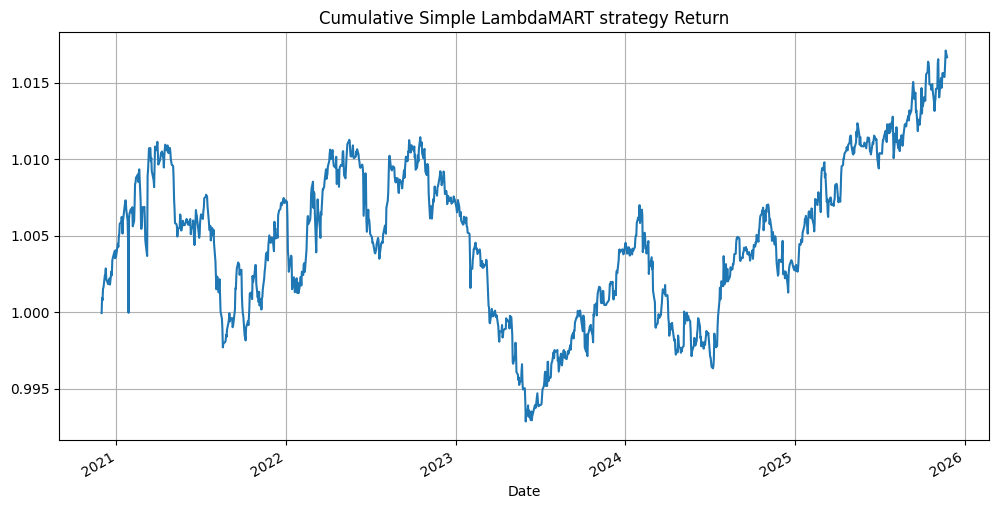

In [ ]:
(1+results_df['ls_ret']*1e-4).cumprod().plot(figsize=(12,6), title='Cumulative Simple LambdaMART strategy Return', grid=True)

In [ ]:
print('Sharpe for the Simple LambdaMART strategy:', round(results_df['ls_ret'].mean()/results_df['ls_ret'].std()*np.sqrt(252), 3))

Sharpe for the Simple LambdaMART strategy: 0.319


In [ ]:
DICT_ALL_RESULTS['Simple LambdaMART strategy'] = results_df['ls_ret']

### Hyperparameter optimization

In [ ]:
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import ndcg_score

In [ ]:
param_distributions = {
    'num_leaves': [20, 31, 50, 75],
    'learning_rate': [0.005, 0.01, 0.03],
    'n_estimators': [100, 200, 300, 500],
    'min_child_samples': [50, 100, 150, 200, 500],
    'min_child_weight': [0.01, 0.1, 1],
    'reg_alpha': [0.1, 1, 5, 10],
    'reg_lambda': [0.1, 1, 5, 10],
    'subsample': [0.7, 0.8, 0.85],
    'subsample_freq': [1],
    'colsample_bytree': [0.7, 0.8, 0.85],
    'max_depth': [5, 7, 9],
}

In [ ]:
cv = ExpandingWindowCV(n_splits=3)

In [ ]:
param_list = list(ParameterSampler(param_distributions, n_iter=100, random_state=42))

In [ ]:
results = []

for i, params in tqdm(enumerate(param_list)):
    cv_scores = []
    
    for train_idx, val_idx in cv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train_ranks_short.iloc[train_idx], y_train_ranks_short.iloc[val_idx]
        
        group_tr = X_tr.groupby('Date').size().values
        group_val = X_val.groupby('Date').size().values
        
        model = LGBMRanker(
            objective='lambdarank',
            metric='ndcg',
            boosting_type='gbdt',
            n_jobs=-1,
            random_state=42,
            **params
        )
        
        model.fit(
            X_tr, y_tr,
            group=group_tr,
        )
        
        y_pred_val = model.predict(X_val)
        sizes = group_val
        start = 0
        ndcgs = []
        for size in sizes:
            end = start + size
            ndcgs.append(ndcg_score([y_val.iloc[start:end]], [y_pred_val[start:end]],))
            start = end
        cv_scores.append(np.mean(ndcgs))
    
    mean_score = np.mean(cv_scores)
    std_score = np.std(cv_scores)
    
    results.append({**params, 'mean_test_score': mean_score, 'std_test_score': std_score})
    
    print(f"Iter {i+1}/100: NDCG = {mean_score:.4f} ± {std_score:.4f}")


In [ ]:
results_df = pd.DataFrame(results)

param_cols = [col for col in results_df.columns if col not in ['mean_test_score', 'std_test_score']]
plot_df = results_df[param_cols + ['mean_test_score', 'std_test_score']].copy()

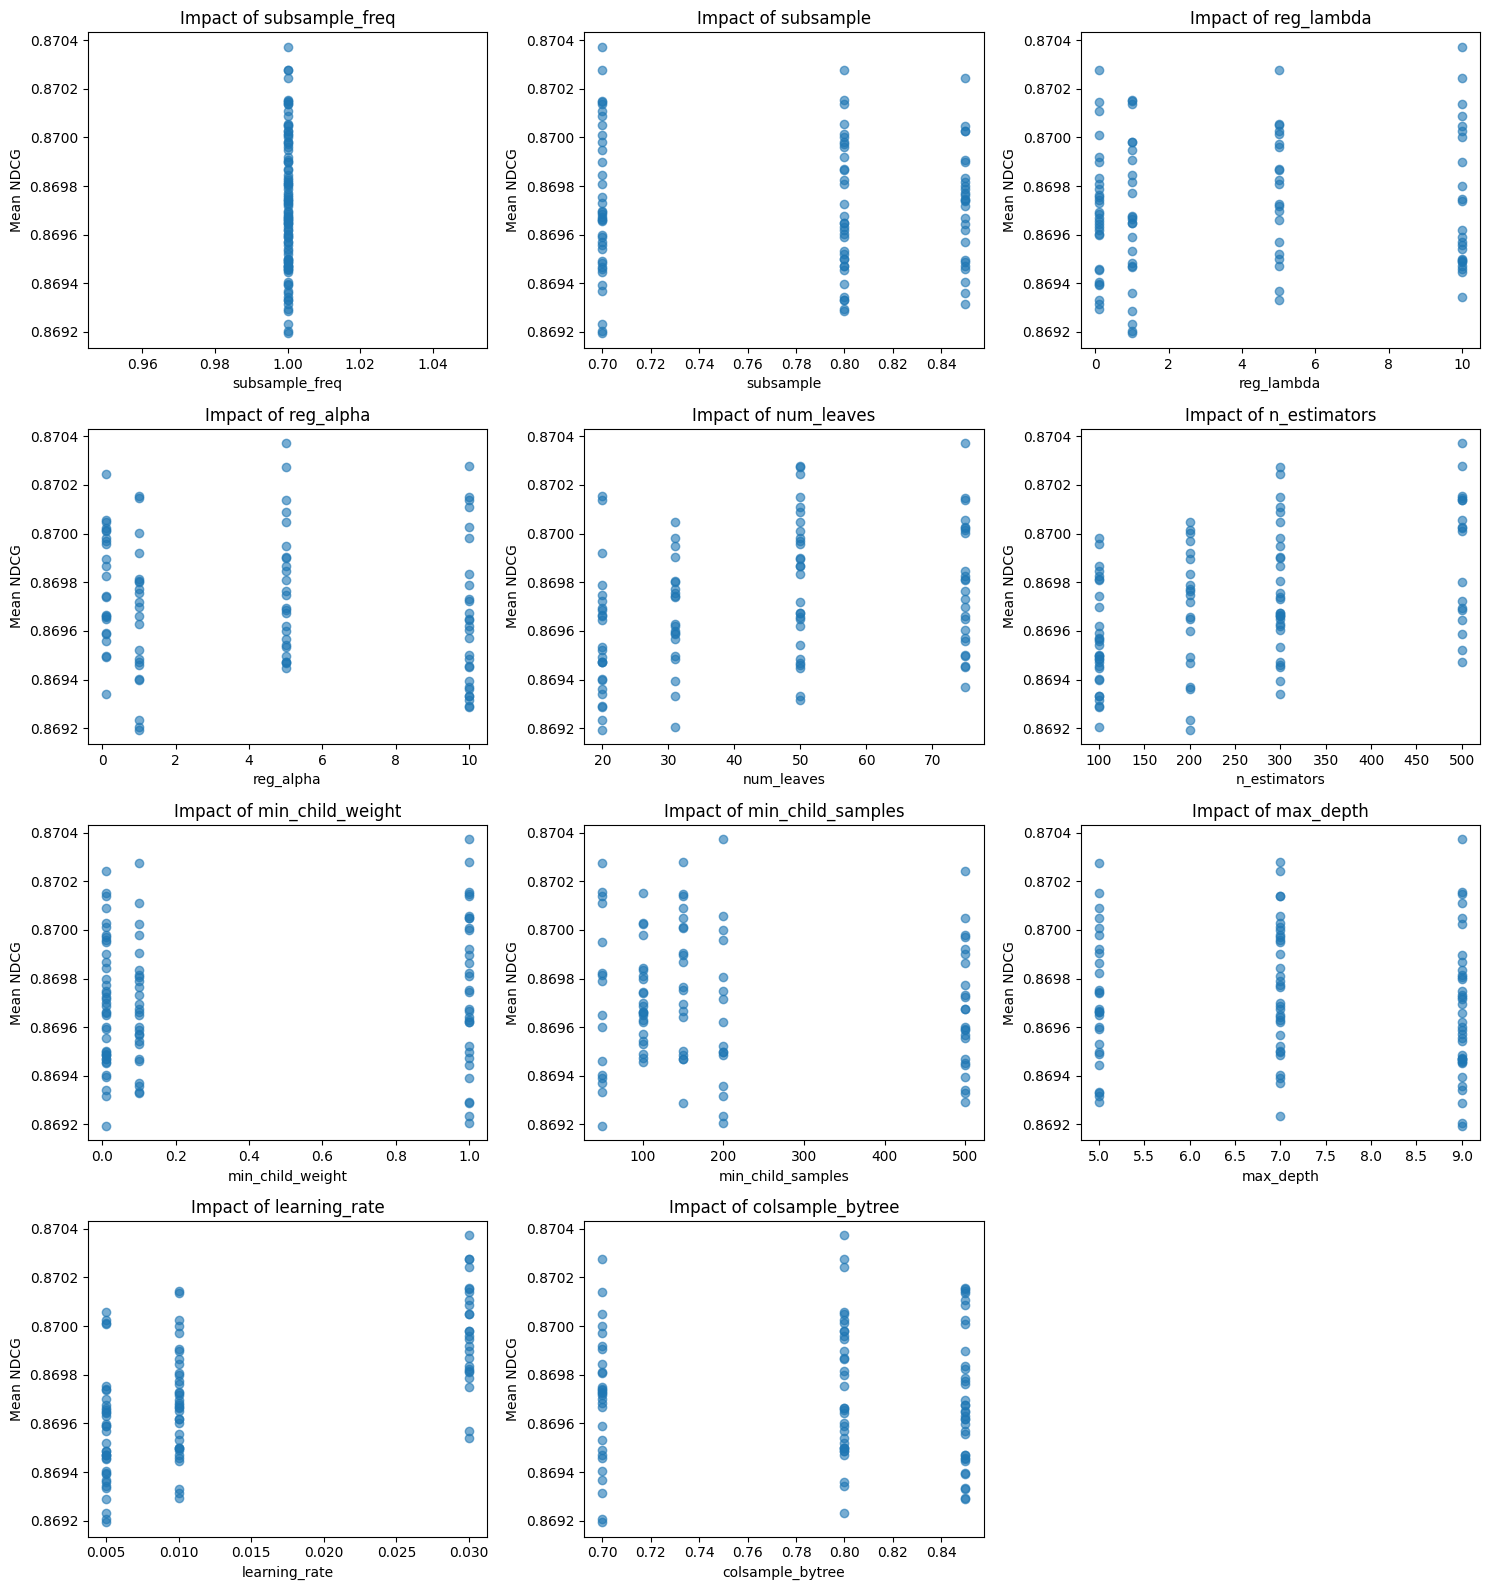

In [ ]:
params = [col for col in plot_df.columns if col not in ['mean_test_score', 'std_test_score']]
n_params = len(params)
n_cols = 3
n_rows = math.ceil(n_params / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for idx, param in enumerate(params):
    ax = axes[idx]
    ax.scatter(plot_df[param], plot_df['mean_test_score'], alpha=0.6)
    ax.set_xlabel(param)
    ax.set_ylabel('Mean NDCG')
    ax.set_title(f'Impact of {param}')

for idx in range(len(params), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

### Adjusted model

In [ ]:
hyperparameters_long = {
    'num_leaves': 20,
    'learning_rate': 0.01,
    'n_estimators': 100,
    'min_child_samples': 100,
    'min_child_weight': 0.01,
    'reg_alpha': 1,
    'reg_lambda': 0.1,
    'subsample': 0.85,
    'subsample_freq': 1,
    'colsample_bytree': 0.85,
    'max_depth': 9,
}

In [ ]:
hyperparameters_short = {
    'num_leaves': 20,
    'learning_rate': 0.005,
    'n_estimators': 200,
    'min_child_samples': 500,
    'min_child_weight': 0.01,
    'reg_alpha': 1,
    'reg_lambda': 1,
    'subsample': 0.85,
    'subsample_freq': 1,
    'colsample_bytree': 0.7,
    'max_depth': 9,
}

In [ ]:
model_long = LGBMRanker(**hyperparameters_long)

In [ ]:
model_short = LGBMRanker(**hyperparameters_short)

In [ ]:
model_long.fit(X_train, y_train_ranks_long, group=train_groups)

,boosting_type,'gbdt'
,num_leaves,20
,max_depth,9
,learning_rate,0.01
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.01
,min_child_samples,100


In [ ]:
model_short.fit(X_train, y_train_ranks_short, group=train_groups)

,boosting_type,'gbdt'
,num_leaves,20
,max_depth,9
,learning_rate,0.005
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.01
,min_child_samples,500


In [ ]:
test_scores_long = model_long.predict(X_test.values)
test_scores_short = model_short.predict(X_test.values)
X_test_scored = X_test.copy()
X_test_scored['score_long'] = test_scores_long
X_test_scored['score_short'] = test_scores_short
X_test_scored['actual_return'] = clean_df.loc[split_date:, "close_1d_ret"]
X_test_scored['Ticker'] = clean_df.loc[split_date:, "Ticker"]
X_test_scored = X_test_scored.merge(df[['Ticker', 'vol_target_weight']], on=['Date', 'Ticker'], how='left')
results_df = pd.DataFrame({
    'long_ret': X_test_scored.groupby('Date').apply(lambda x: (x.sort_values('score_long', ascending=False).head(35)['actual_return']*x.sort_values('score_long', ascending=False).head(35)['vol_target_weight']).mean()),
    'short_ret': X_test_scored.groupby('Date').apply(lambda x: (x.sort_values('score_short', ascending=False).head(35)['actual_return']*x.sort_values('score_short', ascending=False).head(35)['vol_target_weight']).mean())
})
results_df['ls_ret'] = (results_df['long_ret'] - results_df['short_ret'])*0.5

/opt/python/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRanker was fitted with feature names
  warnings.warn(


<Axes: title={'center': 'Cumulative ajdusted LambdaMART Strategy Return'}, xlabel='Date'>

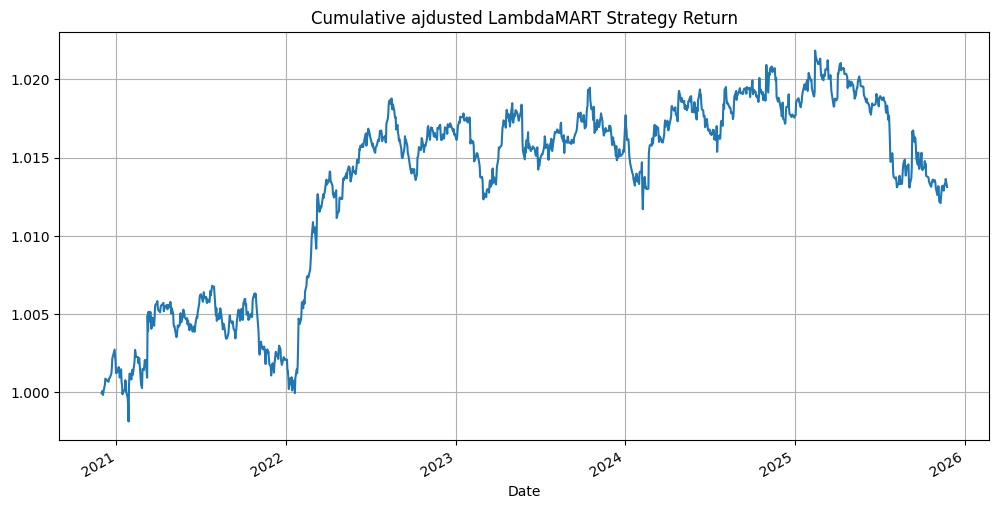

In [ ]:
(1+results_df['ls_ret']*1e-4).cumprod().plot(figsize=(12,6), title='Cumulative ajdusted LambdaMART Strategy Return', grid=True)

In [ ]:
print('Sharpe for the Adjusted LambdaMART strategy:', round(results_df['ls_ret'].mean()/results_df['ls_ret'].std()*np.sqrt(252), 3))

Sharpe for the Adjusted LambdaMART strategy: 0.362


In [ ]:
DICT_ALL_RESULTS['Adjusted LambdaMART strategy'] = results_df['ls_ret']

## ListNet Listwise

In [ ]:
df = pd.read_parquet("df_all_features.pq")

In [ ]:
### Imports for listwise algorithm

from typing import List, Tuple
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
### 0) CONFIG 

target_col = "close_1d_ret_hedged_normalised"   # target 
realized_ret_col = "close_1d_ret"              # return to backtest 
TOP_K = 35

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
np.random.seed(0)


In [ ]:
### 1) SAFETY: keep only numeric features

def filter_numeric_features(df: pd.DataFrame, feature_cols: List[str]) -> List[str]:
    keep = []
    dropped = []
    for c in feature_cols:
        if c not in df.columns:
            dropped.append((c, "missing"))
            continue
        if pd.api.types.is_numeric_dtype(df[c]):
            keep.append(c)
        else:
            dropped.append((c, str(df[c].dtype)))
    print(f"[Feature filter] kept={len(keep)} dropped={len(dropped)}")
    if dropped:
        print("[Feature filter] examples dropped:", dropped[:10], "..." if len(dropped) > 10 else "")
    return keep


### 2) Build query lists: group by Date (index)

def make_query_lists(df_in: pd.DataFrame, feature_cols: List[str], target_col: str, realized_ret_col: str):
    """
    Returns list of queries: each item = (Xq, yq, rq, date)
    Xq: (N_assets, n_features)
    yq: (N_assets,) training target for ranking
    rq: (N_assets,) realized returns for evaluation (raw column)
    """
    queries = []
    for date, g in df_in.groupby(level=0):
        g = g.dropna(subset=feature_cols + [target_col, realized_ret_col])
        if len(g) < 2:
            continue
        Xq = g[feature_cols].to_numpy(dtype=np.float32)
        yq = g[target_col].to_numpy(dtype=np.float32)
        rq = g[realized_ret_col].to_numpy(dtype=np.float32)
        queries.append((Xq, yq, rq, date))
    return queries


### 3) Dataset + collate for variable-length lists

class QueryDataset(Dataset):
    def __init__(self, queries):
        self.queries = queries
    def __len__(self):
        return len(self.queries)
    def __getitem__(self, idx):
        return self.queries[idx]

def collate_queries(batch):
    # batch is list of tuples (Xq, yq, rq, date)
    return batch  # keep variable lengths

In [ ]:
### 4) ListNet model

class ListNetMLP(nn.Module):
    def __init__(self, d_in: int, hidden: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        # x: (N, d_in)
        return self.net(x).squeeze(-1)  # (N,)


def listnet_loss(scores: torch.Tensor, labels: torch.Tensor):
    """
    Classic ListNet: cross-entropy between softmax(labels) and softmax(scores).
    labels: relevance (continuous ok), scores: predicted.
    """
    p_true = F.softmax(labels, dim=0)
    p_pred = F.log_softmax(scores, dim=0)
    return -(p_true * p_pred).sum()

In [ ]:
### 5) Return conversion helpers + sharpe + stable cumprod

def bps_to_decimal(r: pd.Series) -> pd.Series:
    return r.astype(float) / 10000.0

def sharpe_ratio(daily_ret: pd.Series, periods_per_year=252):
    daily_ret = daily_ret.dropna()
    if len(daily_ret) < 2:
        return np.nan
    mu = daily_ret.mean()
    sigma = daily_ret.std(ddof=1)
    if sigma == 0:
        return np.nan
    return (mu / sigma) * np.sqrt(periods_per_year)

def stable_cumprod(daily_ret: pd.Series):
    # avoid overflow: exp(cumsum(log1p(r)))
    r = daily_ret.fillna(0.0).clip(lower=-0.99)
    return np.exp(np.log1p(r).cumsum())

In [ ]:
### 6) Train + predict per query

def train_listnet(train_queries, feature_dim, epochs=8, lr=1e-3, batch_size=16):
    model = ListNetMLP(feature_dim, hidden=128).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    loader = DataLoader(QueryDataset(train_queries), batch_size=batch_size, shuffle=True, collate_fn=collate_queries)

    for ep in range(1, epochs+1):
        model.train()
        losses = []
        for batch in loader:
            opt.zero_grad()
            batch_loss = 0.0

            # each element is one query (variable length list)
            for Xq, yq, rq, date in batch:
                X = torch.tensor(Xq, device=device)
                y = torch.tensor(yq, device=device)

                scores = model(X)
                loss = listnet_loss(scores, y)
                batch_loss = batch_loss + loss

            batch_loss = batch_loss / len(batch)
            batch_loss.backward()
            opt.step()
            losses.append(batch_loss.item())

        print(f"Epoch {ep}/{epochs} - loss={np.mean(losses):.6f}")

    return model


def predict_scores(model, queries):
    """
    Returns: list of (date, scores_np, realized_np)
    """
    model.eval()
    out = []
    with torch.no_grad():
        for Xq, yq, rq, date in queries:
            X = torch.tensor(Xq, device=device)
            scores = model(X).detach().cpu().numpy()
            out.append((date, scores, rq))
    return out

In [ ]:
### 7) Evaluation: long/short + bucket plot + best/worst CG day

def evaluate_and_plot(pred_list, top_k=35, title_prefix="ListNet"):
    """
    pred_list: list (date, scores, realized_raw)
    realized_raw here is in bps -> converted to decimal
    """

    daily_rows = []
    bucket_rows = []

    for date, scores, realized_raw in pred_list:
        # realized_raw are bps (given your stats) -> convert to decimal
        realized = realized_raw.astype(float) / 10000.0

        dfq = pd.DataFrame({"score": scores, "ret": realized}).dropna()
        if len(dfq) < 2:
            continue

        dfq = dfq.sort_values("score", ascending=False)
        k = min(top_k, len(dfq)//2)  # safety

        long_ret = dfq.head(k)["ret"].mean()
        short_ret = dfq.tail(k)["ret"].mean()
        ls_ret = long_ret - short_ret
        daily_rows.append((date, long_ret, short_ret, ls_ret))

        # bucket analysis (deciles)
        dfq["bucket"] = pd.qcut(dfq["score"], 10, labels=False, duplicates="drop")
        bucket_mean = dfq.groupby("bucket")["ret"].mean()
        for b, v in bucket_mean.items():
            bucket_rows.append((date, int(b), float(v)))

    daily_df = pd.DataFrame(daily_rows, columns=["date", "long", "short", "long_short"]).set_index("date").sort_index()
    if daily_df.empty:
        print("No daily rows to evaluate.")
        return

    daily_df["cum_long"] = stable_cumprod(daily_df["long"])
    daily_df["cum_short"] = stable_cumprod(daily_df["short"])
    daily_df["cum_ls"] = stable_cumprod(daily_df["long_short"])

    # Sharpe
    sharpe_long = sharpe_ratio(daily_df["long"])
    sharpe_short = sharpe_ratio(daily_df["short"])
    sharpe_ls = sharpe_ratio(daily_df["long_short"])

    print("Sharpe (annualized):")
    print("  Long:", sharpe_long)
    print("  Short:", sharpe_short)
    print("  Long-Short:", sharpe_ls)

    # ---- Plot 1: Long-Short cumulative ----
    plt.figure()
    plt.plot(daily_df.index, daily_df["cum_ls"])
    plt.title(f"{title_prefix} Long-Short Cumulative Return (Top/Bottom {top_k})")
    plt.xlabel("Date")
    plt.ylabel("Cumulative (stable)")
    plt.grid(True)
    plt.show()

    # ---- Plot 2: Long vs Short cumulative ----
    plt.figure()
    plt.plot(daily_df.index, daily_df["cum_long"], label="Long")
    plt.plot(daily_df.index, daily_df["cum_short"], label="Short")
    plt.title(f"{title_prefix} Long vs Short Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative (stable)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---- Plot 3: bucket returns (average over test) ----
    bucket_df = pd.DataFrame(bucket_rows, columns=["date", "bucket", "ret"])
    if not bucket_df.empty:
        avg_bucket = bucket_df.groupby("bucket")["ret"].mean()
        plt.figure()
        plt.bar(avg_bucket.index.astype(str), avg_bucket.values)
        plt.title("Average Realized Return by Score Bucket (test)")
        plt.xlabel("bucket")
        plt.ylabel("avg daily return (decimal)")
        plt.grid(True, axis="y")
        plt.show()

    # ---- Plot 4: Cumulative Gain curve - best vs worst day ----
    # define "CG" as cumulative sum of realized returns after sorting by score (within day)
    best_day = None
    worst_day = None
    best_val = -np.inf
    worst_val = np.inf

    for date, scores, realized_raw in pred_list:
        realized = realized_raw.astype(float) / 10000.0
        dfq = pd.DataFrame({"score": scores, "ret": realized}).dropna()
        if len(dfq) < 10:
            continue
        dfq = dfq.sort_values("score", ascending=False)
        cg = dfq["ret"].cumsum().iloc[-1]  # total (end of curve)
        if cg > best_val:
            best_val = cg
            best_day = (date, dfq["ret"].cumsum().values)
        if cg < worst_val:
            worst_val = cg
            worst_day = (date, dfq["ret"].cumsum().values)

    if best_day and worst_day:
        # random baseline from best day
        date_best, cg_best = best_day
        _, cg_worst = worst_day

        # rebuild best day df to shuffle
        for date, scores, realized_raw in pred_list:
            if date == date_best:
                realized = realized_raw.astype(float) / 10000.0
                dfq = pd.DataFrame({"score": scores, "ret": realized}).dropna()
                break
        rnd = dfq.sample(frac=1.0, random_state=0)["ret"].cumsum().values

        plt.figure()
        plt.plot(cg_best, label=f"Best day {date_best} (ranked)")
        plt.plot(cg_worst, label=f"Worst day (ranked)")
        plt.plot(rnd, "--", label="Random baseline (best day shuffled)")
        plt.title("Cumulative Gain Curve (single day)")
        plt.xlabel("Rank position")
        plt.ylabel("Cumulative sum of realized returns (decimal)")
        plt.legend()
        plt.grid(True)
        plt.show()

--- 1. Time split ---
Split Date: 2020-09-18 00:00:00
--- 2. Features selection ---
Numerical Features : 265
--- 3. Removal of NaN/Inf ---
Train queries: 4958 Test queries: 1303
Epoch 1/8 - loss=865169.912834
Epoch 2/8 - loss=397908.068479
Epoch 3/8 - loss=229806.254480
Epoch 4/8 - loss=153980.508564
Epoch 5/8 - loss=68811.828367
Epoch 6/8 - loss=52041.455540
Epoch 7/8 - loss=46291.841943
Epoch 8/8 - loss=18430.845329
Sharpe (annualized):
  Long: 0.5210577503864765
  Short: 0.4359445896163349
  Long-Short: 0.3297314820686383


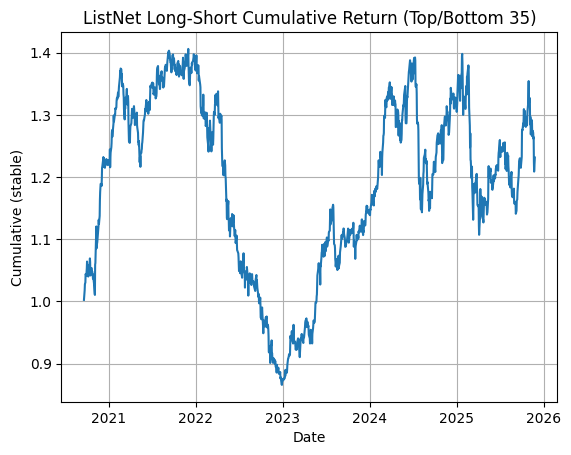

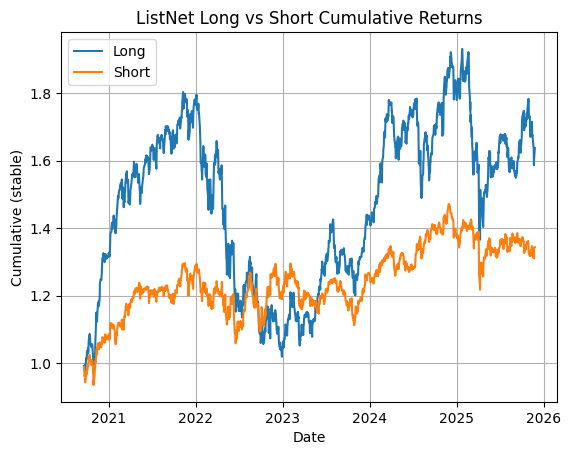

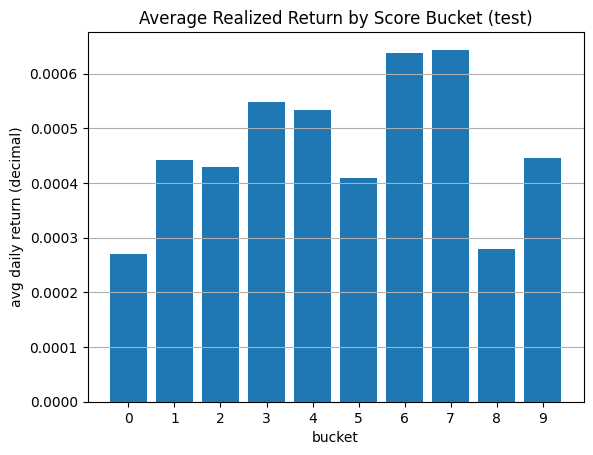

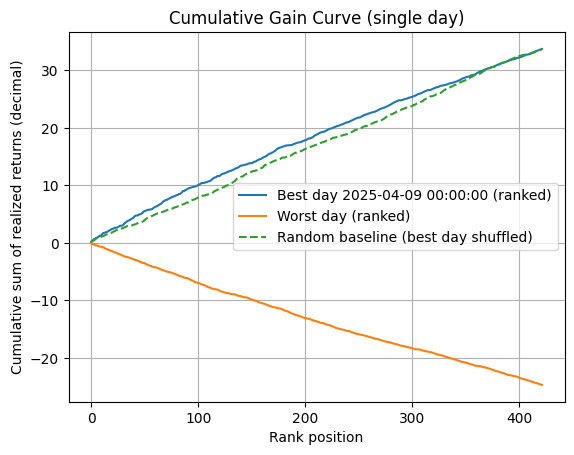

In [ ]:
### 8) RUN PIPELINE

print("--- 1. Time split ---")
df = df.sort_index()
dates = df.index.unique().sort_values()
split_idx = int(len(dates) * 0.80)
split_date = dates[split_idx]

df_train = df[df.index < split_date].copy()
df_test = df[df.index >= split_date].copy()
print(f"Split Date: {split_date}")

print("--- 2. Features selection ---")

exclude_cols = [
    target_col, 
    realized_ret_col, 
    'Ticker', 
    'id', 
    'close_1d_ret_hedged', # Leakage 
    'relevance', 
    'predicted_score'
]

feature_cols = [c for c in df_train.columns 
                if c not in exclude_cols 
                and pd.api.types.is_numeric_dtype(df_train[c])]

print(f"Numerical Features : {len(feature_cols)}")

print("--- 3. Removal of NaN/Inf ---")
cols_needed = feature_cols + [target_col, realized_ret_col]
df_train = df_train[cols_needed].replace([np.inf, -np.inf], np.nan).dropna()
df_test = df_test[cols_needed].replace([np.inf, -np.inf], np.nan).dropna()

# Build query lists grouped by Date index
train_queries = make_query_lists(df_train, feature_cols, target_col, realized_ret_col)
test_queries  = make_query_lists(df_test,  feature_cols, target_col, realized_ret_col)

print("Train queries:", len(train_queries), "Test queries:", len(test_queries))

# Train ListNet
model = train_listnet(train_queries, feature_dim=len(feature_cols), epochs=8, lr=1e-3, batch_size=16)

# Predict scores on test
pred_list = predict_scores(model, test_queries)

# Evaluate + plots + Sharpe
evaluate_and_plot(pred_list, top_k=TOP_K, title_prefix="ListNet")

In [ ]:
DICT_ALL_RESULTS['ListNet Listwise strategy'] = pred_list

In [ ]:
split_date

Timestamp('2020-11-30 00:00:00')

In [ ]:
cum_returns = {
    name: (1 + series.loc[split_date:]*1e-4).cumprod()
    for name, series in DICT_ALL_RESULTS.items() if name!='Momentum Monthly strategy'
}

df_cum = pd.DataFrame(cum_returns)

In [ ]:
from matplotlib.ticker import FuncFormatter
from itertools import cycle

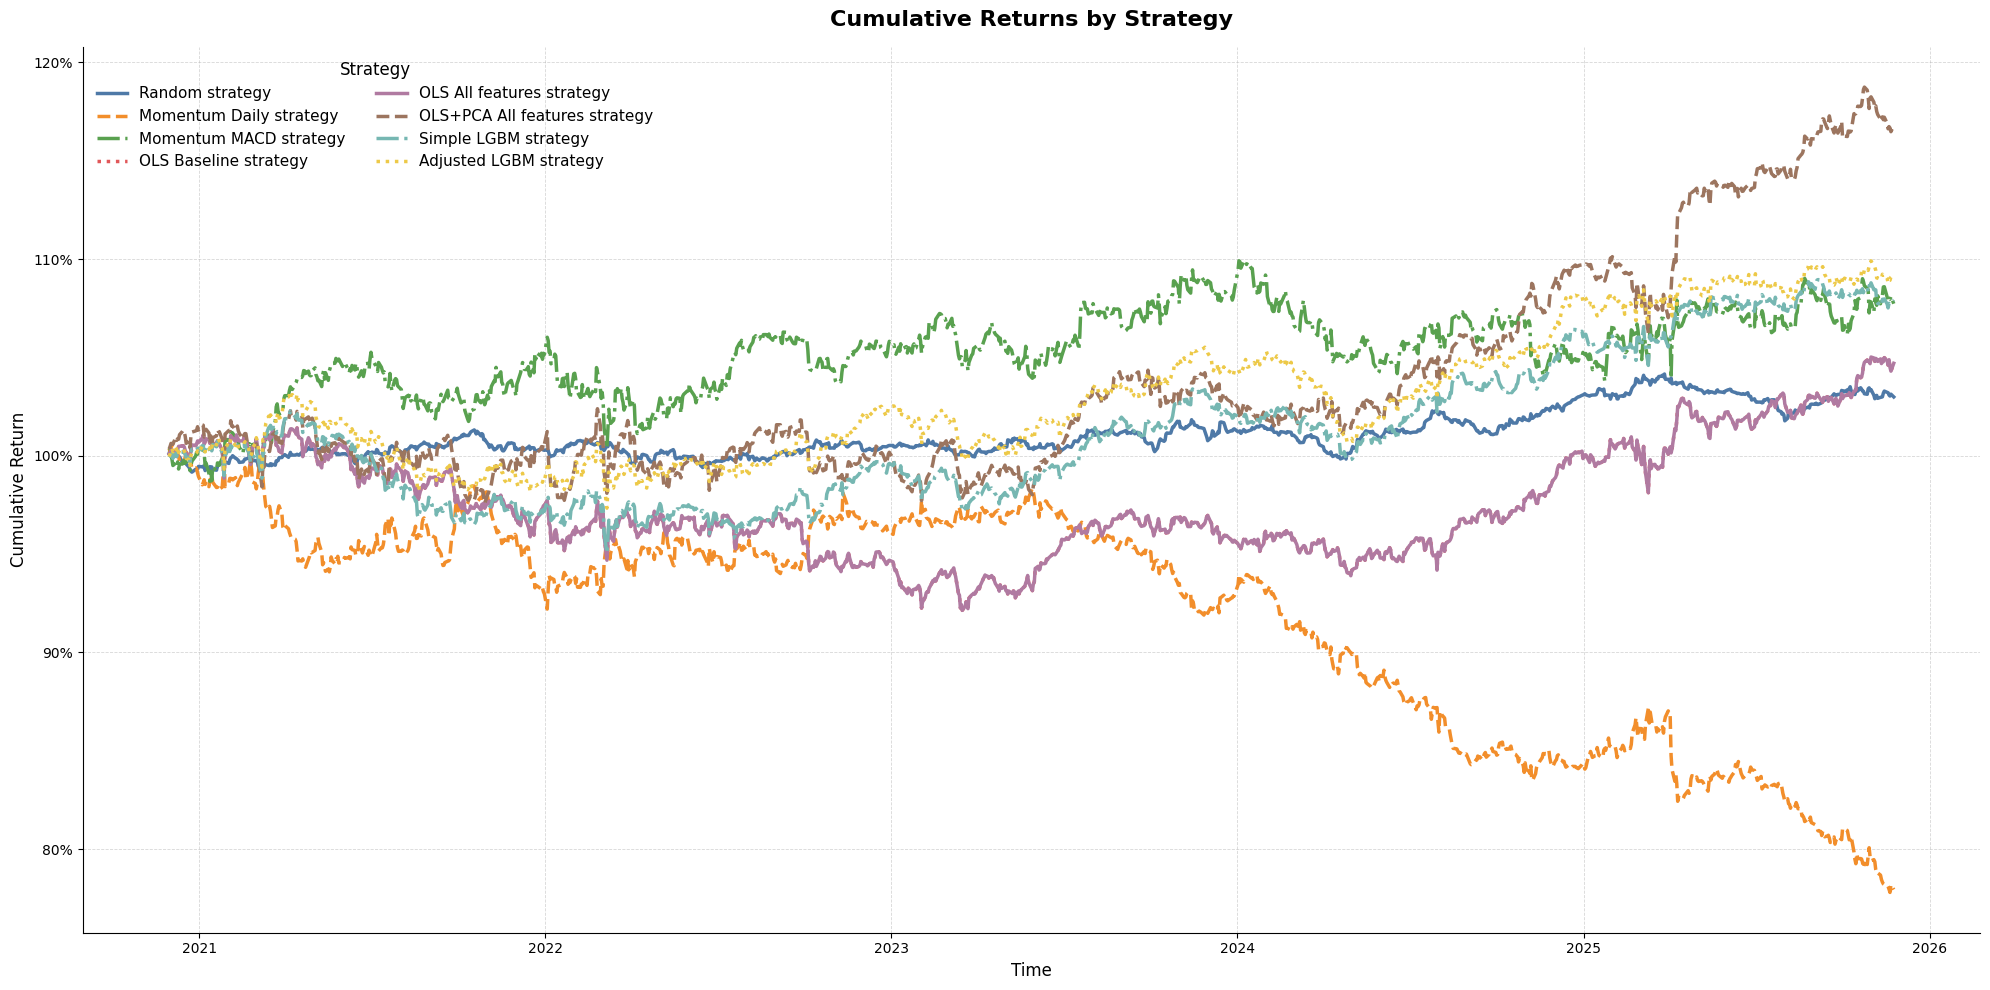

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

# Palette professionnelle très discriminante (Tableau-like)
colors = [
    "#4E79A7",  # bleu
    "#F28E2B",  # orange
    "#59A14F",  # vert
    "#E15759",  # rouge
    "#B07AA1",  # violet
    "#9C755F",  # brun
    "#76B7B2",  # turquoise
    "#EDC948",  # jaune moutarde
    "#FF9DA7",  # Rose / Saumon
]

linestyles = cycle(["-", "--", "-.", ":"])

for (col, series), color, ls in zip(df_cum.items(), colors, linestyles):
    ax.plot(
        series.index,
        series.values,
        label=col,
        color=color,
        linewidth=2.5,
        linestyle=ls
    )

# Titres et labels
ax.set_title("Cumulative Returns by Strategy", fontsize=16, fontweight="bold", pad=15)
ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Cumulative Return", fontsize=12)

# Axe Y en %
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0%}"))

# Grille discrète
ax.grid(which="major", linestyle="--", linewidth=0.6, alpha=0.5)

# Nettoyage visuel
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Légende claire
ax.legend(
    title="Strategy",
    frameon=False,
    fontsize=11,
    title_fontsize=12,
    ncol=2
)

plt.tight_layout()
plt.show()
